# Cardiovascular Disease Prediction using Neural Networks

## SC5002 - Artificial Intelligence Fundamentals & Applications
### Lab 4: Neural Network Classification Project

**Date:** November 12, 2025

---

## Project Overview

This notebook implements a complete machine learning pipeline for predicting cardiovascular disease using Neural Networks. The project follows standard ML practices including:

1. **Data Collection & Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering**
4. **Model Selection**
5. **Model Training & Validation**
6. **Model Evaluation**
7. **Model Deployment**
8. **Overfitting Analysis**
9. **Hyperparameter Tuning**
10. **Case Studies (Success & Failure)**
11. **Discussion & Future Work**

---

**Dataset:** Cardiovascular Disease Dataset  
**Task:** Binary Classification (Predict presence of cardiovascular disease)  
**Target Variable:** `cardio` (0 = No disease, 1 = Disease)

## 📚 Import Libraries and Setup

In [21]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocessing and Metrics
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, auc,
                             confusion_matrix, classification_report, 
                             ConfusionMatrixDisplay)

# Neural Network - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Sklearn Neural Network (for comparison)
from sklearn.neural_network import MLPClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model serialization
import joblib
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 1.26.4
Pandas version: 2.2.2


### 📖 Feature Descriptions

| Feature | Description | Type |
|---------|-------------|------|
| `id` | Patient ID | Integer |
| `age` | Age in days | Integer |
| `gender` | Gender (1=Female, 2=Male) | Categorical |
| `height` | Height in cm | Integer |
| `weight` | Weight in kg | Float |
| `ap_hi` | Systolic blood pressure | Integer |
| `ap_lo` | Diastolic blood pressure | Integer |
| `cholesterol` | Cholesterol level (1=Normal, 2=Above normal, 3=Well above normal) | Categorical |
| `gluc` | Glucose level (1=Normal, 2=Above normal, 3=Well above normal) | Categorical |
| `smoke` | Smoking (0=No, 1=Yes) | Binary |
| `alco` | Alcohol intake (0=No, 1=Yes) | Binary |
| `active` | Physical activity (0=No, 1=Yes) | Binary |
| `cardio` | **Target: Cardiovascular disease** (0=No, 1=Yes) | **Binary** |

## 1️⃣ Data Collection & Loading

In [5]:
# Load the dataset
df = pd.read_csv('cardio_train.csv', delimiter=';')

print("=" * 70)
print("DATASET LOADED SUCCESSFULLY")
print("=" * 70)
print(f"\n📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n🔍 First 5 rows:")
df.head()

DATASET LOADED SUCCESSFULLY

📊 Dataset Shape: 70000 rows × 13 columns

🔍 First 5 rows:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
# Dataset information
print("=" * 70)
print("DATASET INFORMATION")
print("=" * 70)
print("\n📋 Column Names and Data Types:")
print(df.dtypes)
print("\n" + "=" * 70)
df.info()

DATASET INFORMATION

📋 Column Names and Data Types:
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         700

In [7]:
# Basic statistical summary
print("=" * 70)
print("STATISTICAL SUMMARY")
print("=" * 70)
df.describe()

STATISTICAL SUMMARY


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


---
## 2️⃣ Data Preprocessing & Cleaning

### 2.1 Check for Missing Values

In [8]:
# Check for missing values
print("=" * 70)
print("MISSING VALUES CHECK")
print("=" * 70)

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': missing_values.values,
    'Percentage': missing_percentage.values
})

print(missing_df[missing_df['Missing Count'] > 0])

if missing_values.sum() == 0:
    print("\n✅ No missing values found!")
else:
    print(f"\n⚠️ Total missing values: {missing_values.sum()}")

MISSING VALUES CHECK
Empty DataFrame
Columns: [Column, Missing Count, Percentage]
Index: []

✅ No missing values found!


### 2.2 Detect and Analyze Outliers

In [9]:
# Detect outliers using IQR method
numerical_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

print("=" * 70)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 70)

outlier_summary = []

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers': outlier_count,
        'Percentage': f'{outlier_pct:.2f}%'
    })
    
    print(f"\n{col}:")
    print(f"  Valid range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {outlier_count} ({outlier_pct:.2f}%)")

outlier_df = pd.DataFrame(outlier_summary)
print("\n")
print(outlier_df)

OUTLIER DETECTION (IQR Method)

age:
  Valid range: [12169.50, 26821.50]
  Outliers: 4 (0.01%)

height:
  Valid range: [142.50, 186.50]
  Outliers: 519 (0.74%)

weight:
  Valid range: [39.50, 107.50]
  Outliers: 1819 (2.60%)

ap_hi:
  Valid range: [90.00, 170.00]
  Outliers: 1435 (2.05%)

ap_lo:
  Valid range: [65.00, 105.00]
  Outliers: 4632 (6.62%)


  Feature  Lower Bound  Upper Bound  Outliers Percentage
0     age      12169.5      26821.5         4      0.01%
1  height        142.5        186.5       519      0.74%
2  weight         39.5        107.5      1819      2.60%
3   ap_hi         90.0        170.0      1435      2.05%
4   ap_lo         65.0        105.0      4632      6.62%


### 2.3 Data Cleaning

In [10]:
# Clean the dataset
print("=" * 70)
print("DATA CLEANING")
print("=" * 70)

df_clean = df.copy()
initial_rows = len(df_clean)

# 1. Convert age from days to years
df_clean['age'] = df_clean['age'] / 365.25
print(f"\n✅ Converted age from days to years")

# 2. Remove invalid height (< 140 cm or > 210 cm)
before = len(df_clean)
df_clean = df_clean[(df_clean['height'] >= 140) & (df_clean['height'] <= 210)]
removed = before - len(df_clean)
print(f"✅ Removed {removed} rows with invalid height")

# 3. Remove invalid weight (< 40 kg or > 200 kg)
before = len(df_clean)
df_clean = df_clean[(df_clean['weight'] >= 40) & (df_clean['weight'] <= 200)]
removed = before - len(df_clean)
print(f"✅ Removed {removed} rows with invalid weight")

# 4. Remove invalid blood pressure
# Systolic (ap_hi) should be greater than diastolic (ap_lo)
# Reasonable ranges: ap_hi [80, 220], ap_lo [60, 140]
before = len(df_clean)
df_clean = df_clean[
    (df_clean['ap_hi'] > df_clean['ap_lo']) &
    (df_clean['ap_hi'] >= 80) & (df_clean['ap_hi'] <= 220) &
    (df_clean['ap_lo'] >= 60) & (df_clean['ap_lo'] <= 140)
]
removed = before - len(df_clean)
print(f"✅ Removed {removed} rows with invalid blood pressure")

# 5. Remove duplicates
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
removed = before - len(df_clean)
print(f"✅ Removed {removed} duplicate rows")

# Summary
final_rows = len(df_clean)
total_removed = initial_rows - final_rows
removed_pct = (total_removed / initial_rows) * 100

print("\n" + "=" * 70)
print("CLEANING SUMMARY")
print("=" * 70)
print(f"Initial rows:     {initial_rows:,}")
print(f"Final rows:       {final_rows:,}")
print(f"Rows removed:     {total_removed:,} ({removed_pct:.2f}%)")
print(f"Rows retained:    {(final_rows/initial_rows)*100:.2f}%")

DATA CLEANING

✅ Converted age from days to years
✅ Removed 153 rows with invalid height
✅ Removed 46 rows with invalid weight
✅ Removed 1449 rows with invalid blood pressure
✅ Removed 0 duplicate rows

CLEANING SUMMARY
Initial rows:     70,000
Final rows:       68,352
Rows removed:     1,648 (2.35%)
Rows retained:    97.65%


In [22]:
# View cleaned data
print("=" * 70)
print("CLEANED DATASET")
print("=" * 70)
print(f"\nShape: {df_clean.shape}")
print(f"\nFirst 5 rows:")
df_clean.head()

CLEANED DATASET

Shape: (68352, 13)

First 5 rows:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.357290,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.381246,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.627652,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.249144,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.841205,1,156,56.0,100,60,1,1,0,0,0,0


## 3️⃣ Exploratory Data Analysis (EDA)

### 3.1 Target Variable Distribution

TARGET VARIABLE DISTRIBUTION

Class 0 (No Disease):  34,523 (50.51%)
Class 1 (Disease):     33,829 (49.49%)

Class Balance Ratio: 1.02:1


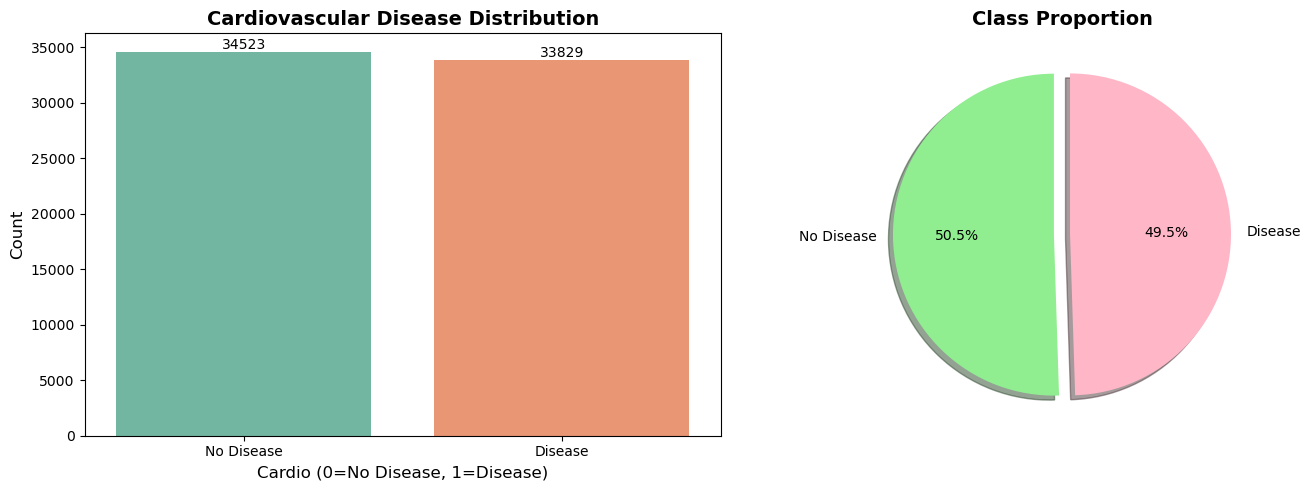


✅ Classes are relatively balanced!


In [11]:
# Analyze target variable distribution
print("=" * 70)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 70)

target_counts = df_clean['cardio'].value_counts()
target_pct = df_clean['cardio'].value_counts(normalize=True) * 100

print(f"\nClass 0 (No Disease):  {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"Class 1 (Disease):     {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nClass Balance Ratio: {target_pct[0]/target_pct[1]:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df_clean, x='cardio', ax=axes[0], palette='Set2')
axes[0].set_title('Cardiovascular Disease Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cardio (0=No Disease, 1=Disease)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Disease', 'Disease'])
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Pie chart
colors = ['#90EE90', '#FFB6C6']
explode = (0.05, 0.05)
axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=explode, shadow=True)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Classes are relatively balanced!")

### 3.2 Numerical Features Distribution

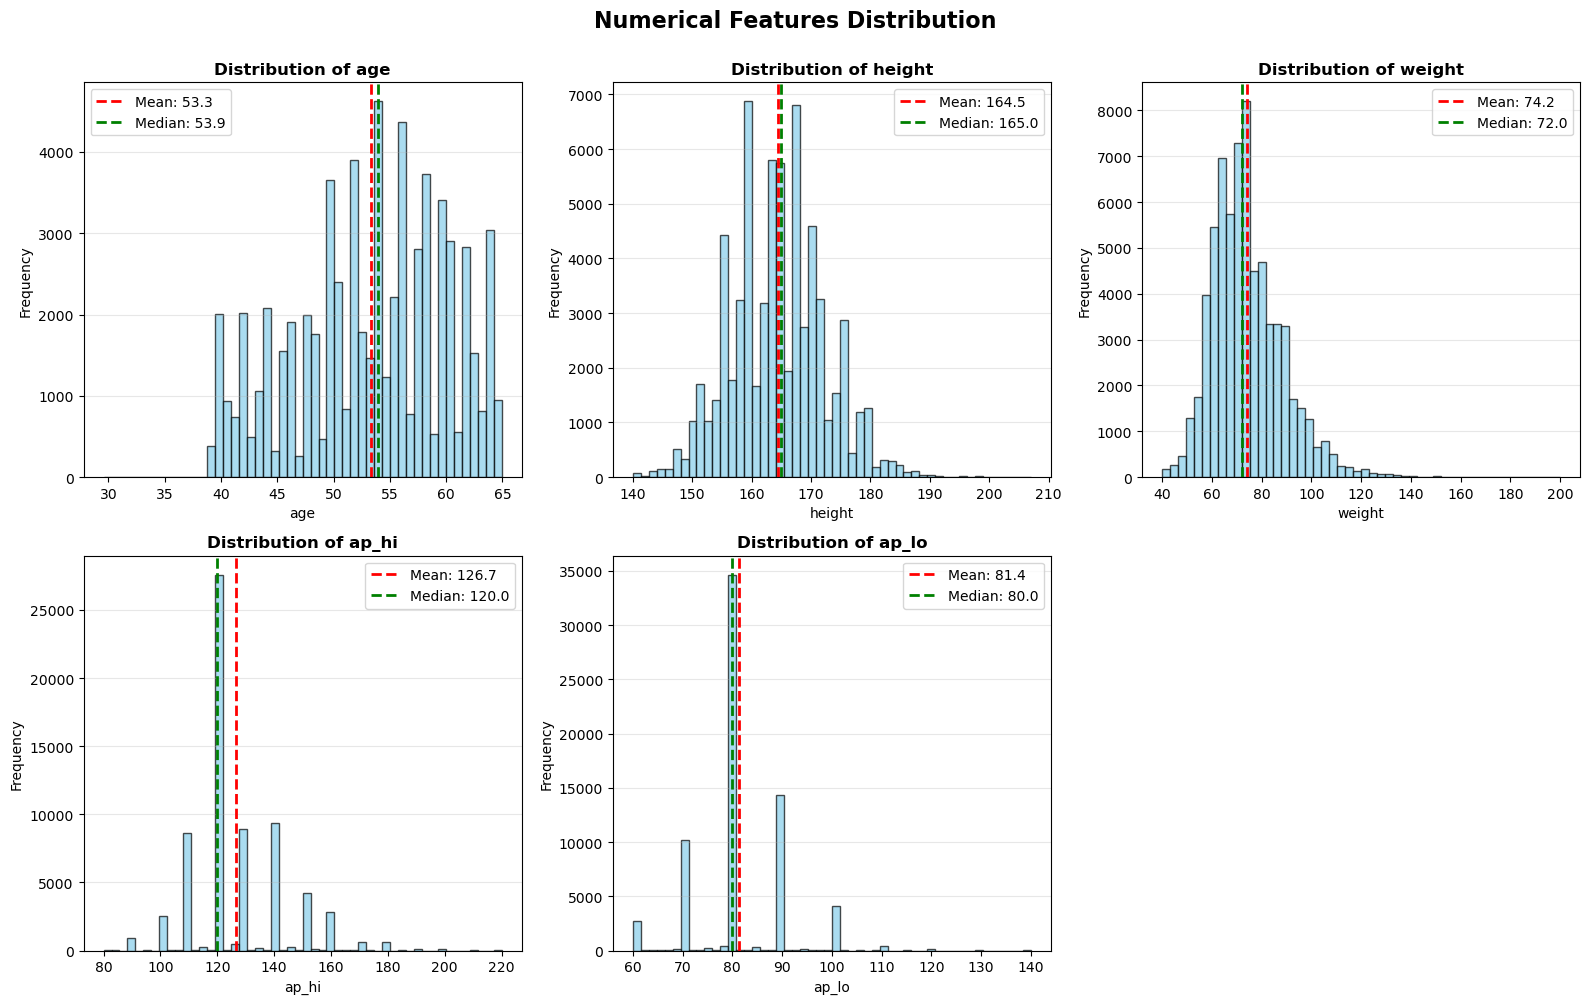

In [12]:
# Distribution of numerical features
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(df_clean[col], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add statistics
    mean_val = df_clean[col].mean()
    median_val = df_clean[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[idx].legend()

axes[5].axis('off')
plt.suptitle('Numerical Features Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.3 Categorical Features Distribution

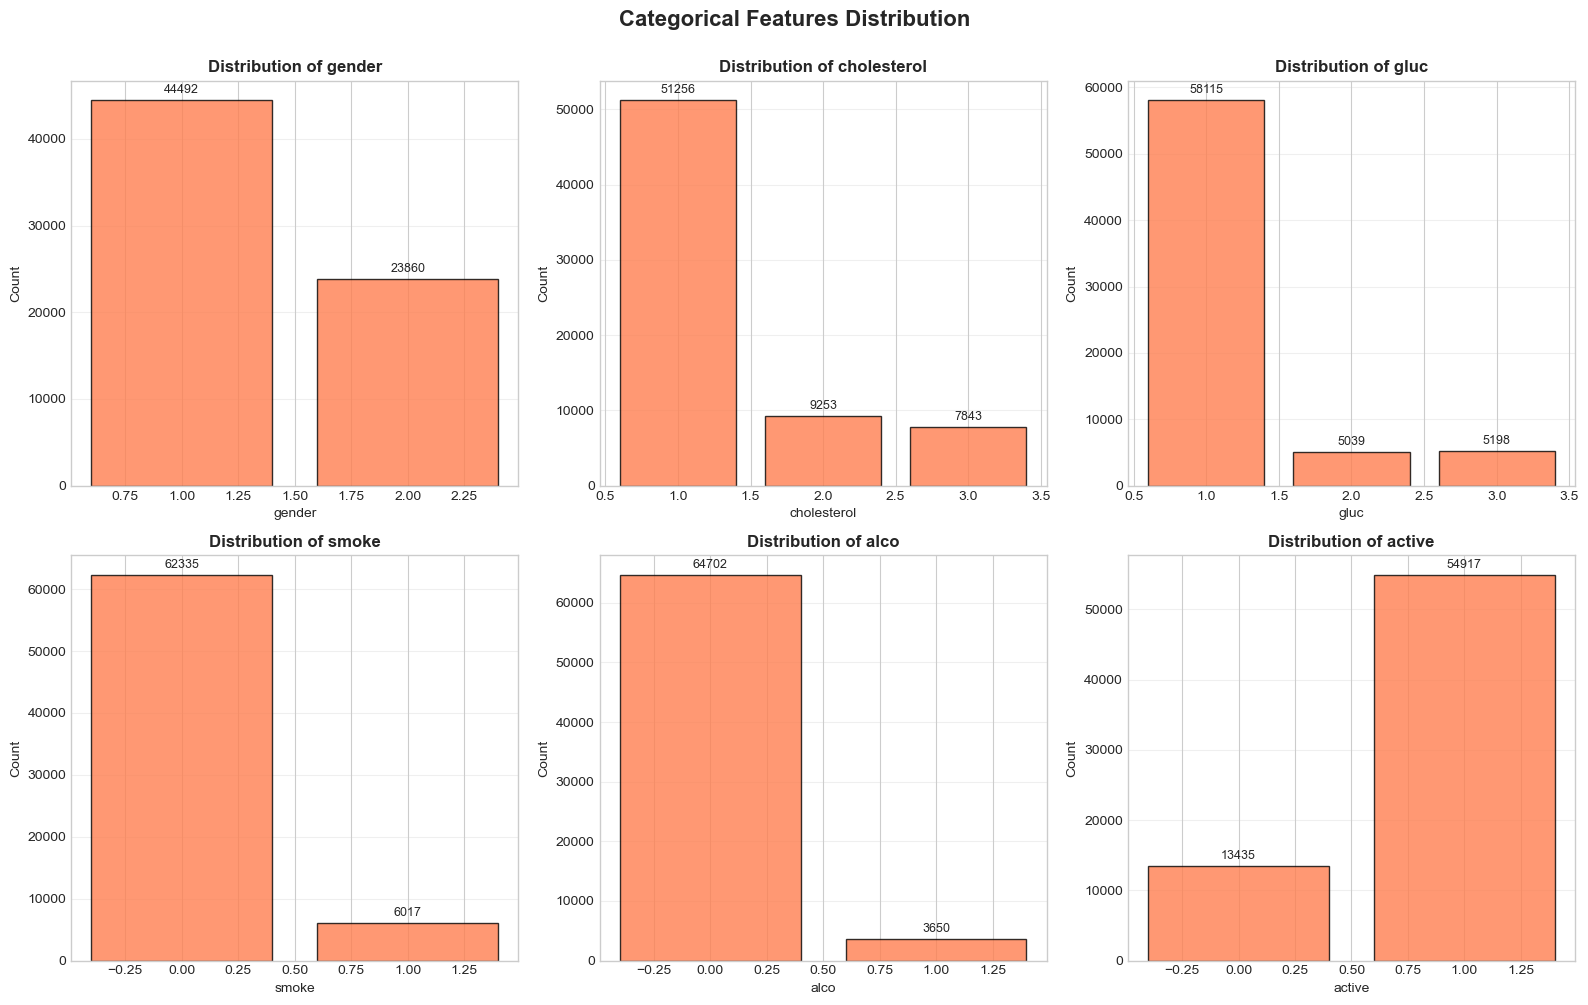

In [27]:
# Distribution of categorical features
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    counts = df_clean[col].value_counts().sort_index()
    axes[idx].bar(counts.index, counts.values, edgecolor='black', alpha=0.8, color='coral')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(counts.values):
        axes[idx].text(counts.index[i], v + max(counts.values)*0.01, str(v), 
                      ha='center', va='bottom', fontsize=9)

plt.suptitle('Categorical Features Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

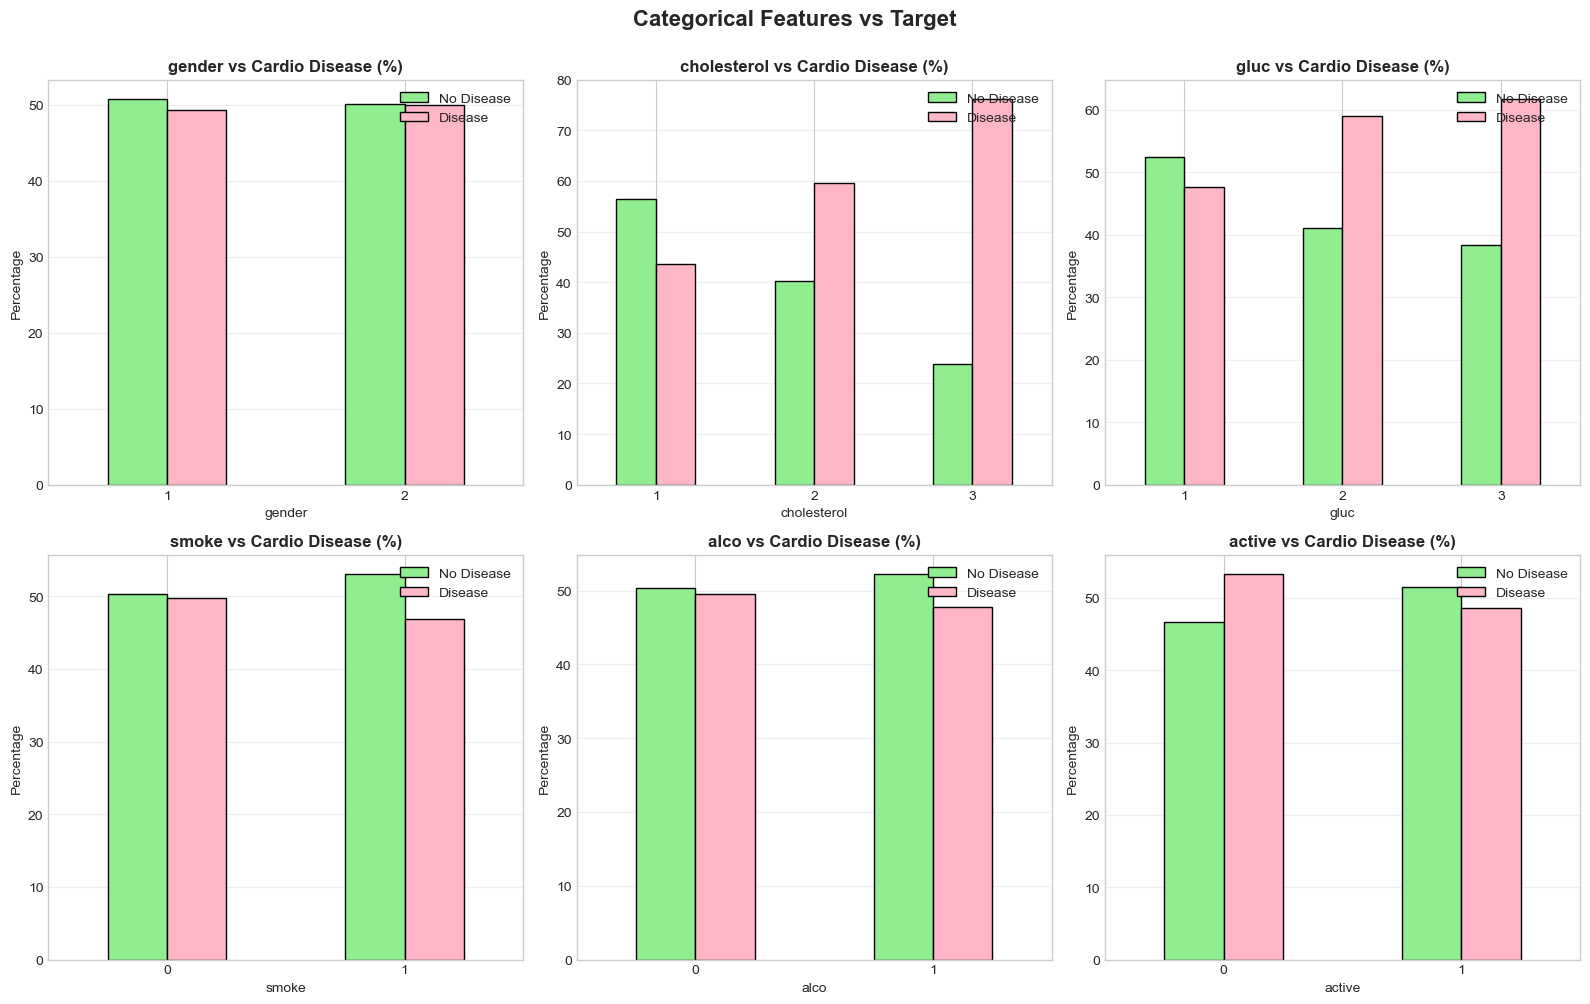

In [29]:
# Categorical features vs target
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    cross_tab = pd.crosstab(df_clean[col], df_clean['cardio'], normalize='index') * 100
    cross_tab.plot(kind='bar', ax=axes[idx], color=['#90EE90', '#FFB6C6'], edgecolor='black')
    axes[idx].set_title(f'{col} vs Cardio Disease (%)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Percentage', fontsize=10)
    axes[idx].legend(['No Disease', 'Disease'], loc='upper right')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)

plt.suptitle('Categorical Features vs Target', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.4 Correlation Analysis

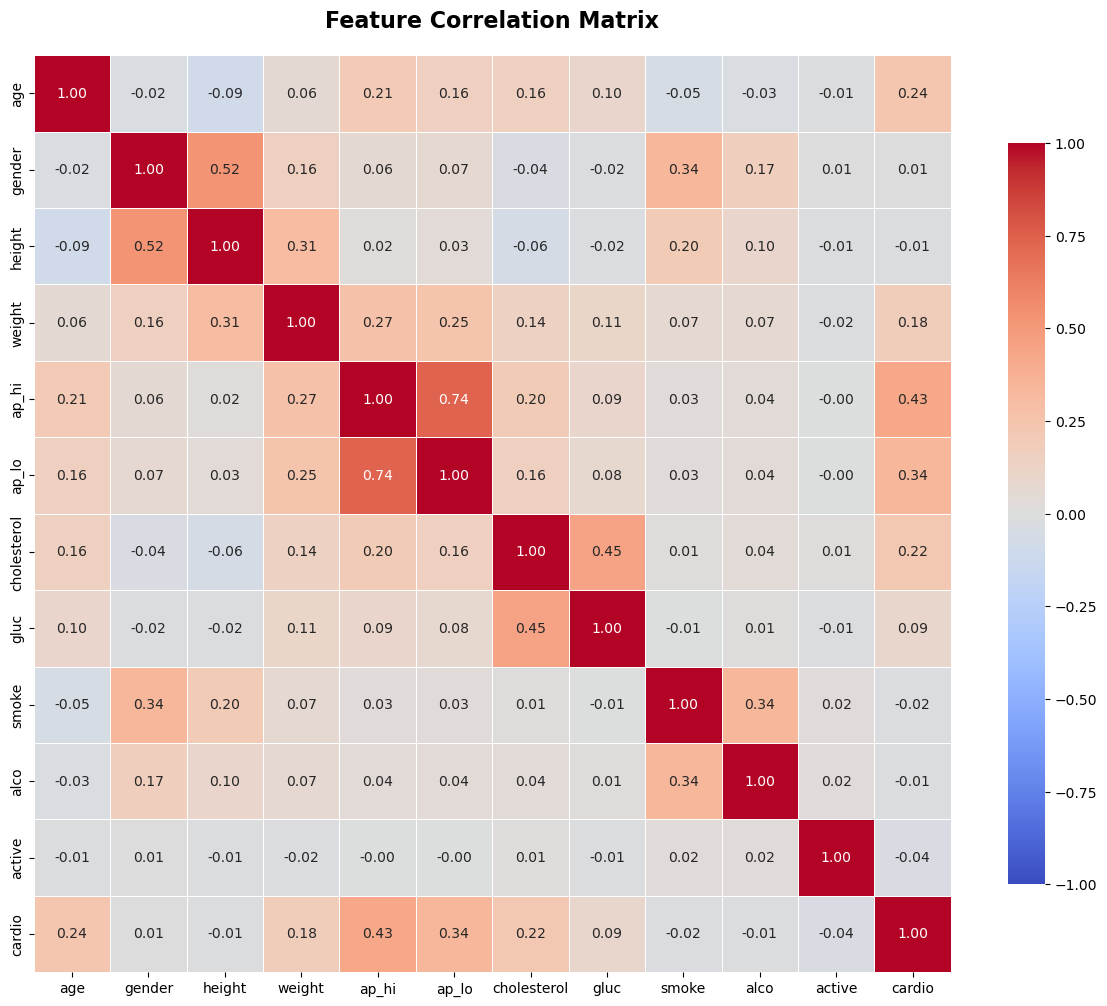

TOP CORRELATIONS WITH TARGET (cardio)
ap_hi          0.428915
ap_lo          0.343170
age            0.239150
cholesterol    0.221255
weight         0.179500
gluc           0.089349
active         0.037974
smoke          0.016106
height         0.013396
alco           0.008391
gender         0.006822


In [14]:
# Correlation matrix
corr_matrix = df_clean.drop('id', axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, center=0)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print top correlations with target
print("=" * 70)
print("TOP CORRELATIONS WITH TARGET (cardio)")
print("=" * 70)
target_corr = corr_matrix['cardio'].abs().sort_values(ascending=False)
print(target_corr[1:].to_string())  # Exclude self-correlation

### 3.5 Feature vs Target Analysis

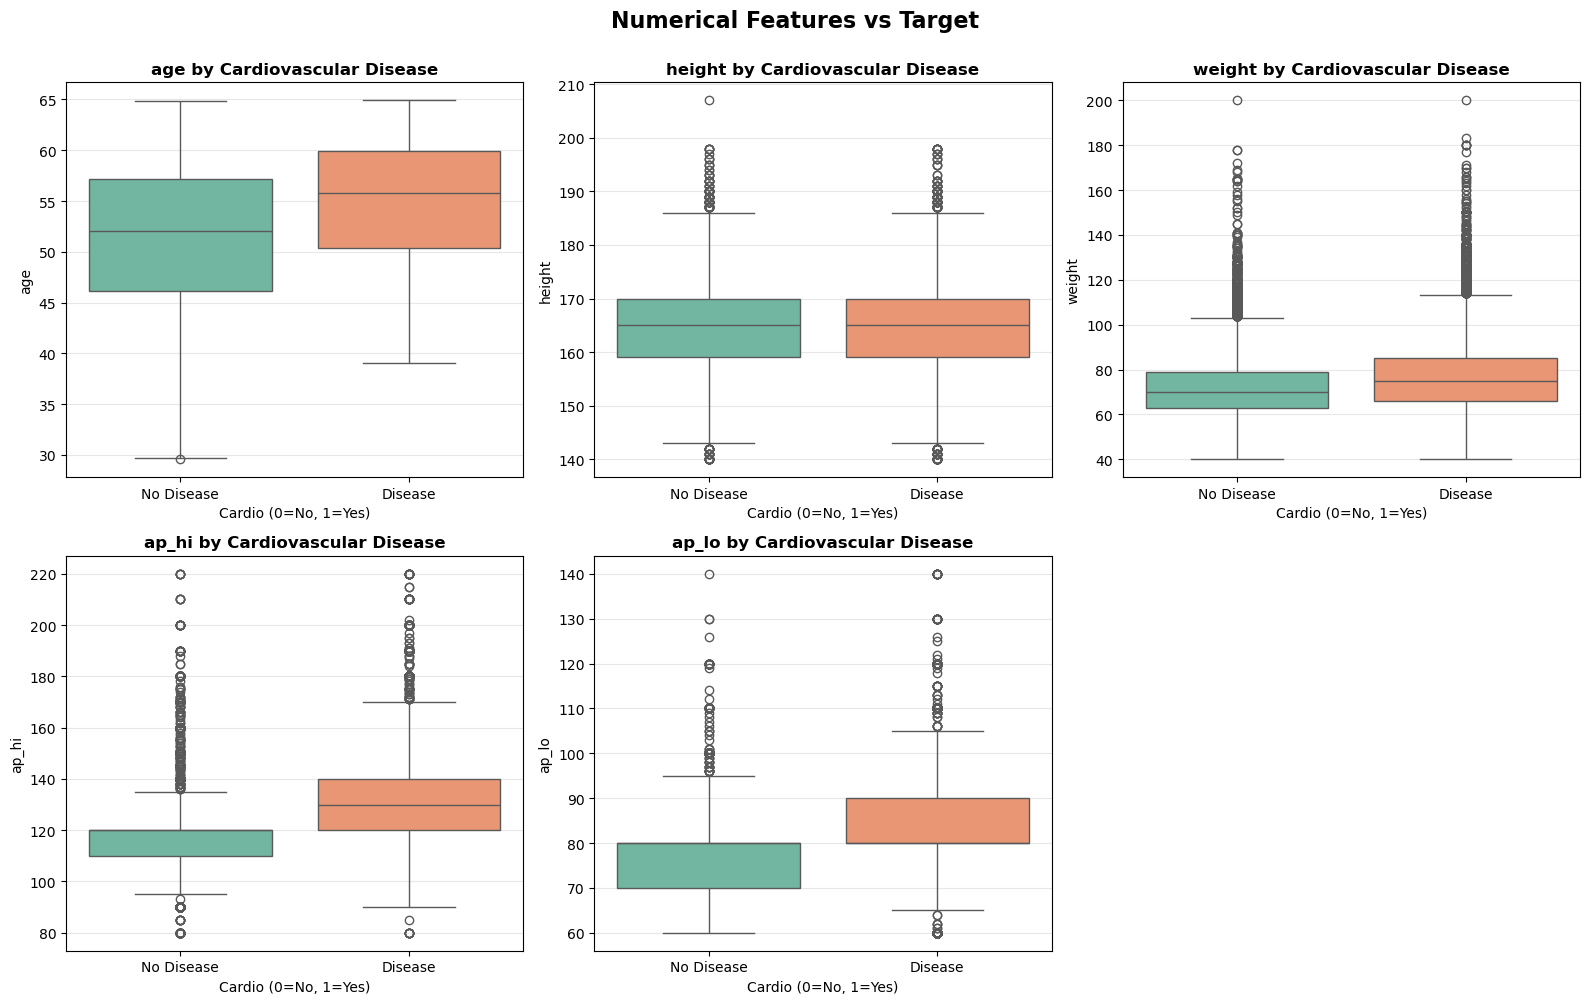

In [15]:
# Box plots for numerical features by cardio status
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=df_clean, x='cardio', y=col, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{col} by Cardiovascular Disease', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cardio (0=No, 1=Yes)', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])
    axes[idx].grid(axis='y', alpha=0.3)

axes[5].axis('off')
plt.suptitle('Numerical Features vs Target', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 4️⃣ Feature Engineering

### 4.1 Create New Features

In [16]:
# Create new features
print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

df_featured = df_clean.copy()

# 1. BMI (Body Mass Index)
df_featured['bmi'] = df_featured['weight'] / ((df_featured['height'] / 100) ** 2)
print("\n✅ Created BMI = weight / (height/100)^2")

# 2. Pulse Pressure
df_featured['pulse_pressure'] = df_featured['ap_hi'] - df_featured['ap_lo']
print("✅ Created Pulse Pressure = systolic - diastolic")

# 3. Mean Arterial Pressure (MAP)
df_featured['map'] = (df_featured['ap_hi'] + 2 * df_featured['ap_lo']) / 3
print("✅ Created MAP = (systolic + 2*diastolic) / 3")

# 4. Age Groups
df_featured['age_group'] = pd.cut(df_featured['age'], 
                                   bins=[0, 40, 50, 60, 100],
                                   labels=[0, 1, 2, 3])
df_featured['age_group'] = df_featured['age_group'].astype(int)
print("✅ Created Age Groups: 0=<40, 1=40-50, 2=50-60, 3=>60")

# 5. BMI Categories
df_featured['bmi_category'] = pd.cut(df_featured['bmi'],
                                      bins=[0, 18.5, 25, 30, 100],
                                      labels=[0, 1, 2, 3])
df_featured['bmi_category'] = df_featured['bmi_category'].astype(int)
print("✅ Created BMI Categories: 0=Underweight, 1=Normal, 2=Overweight, 3=Obese")

# 6. Risk Factors Count
df_featured['risk_factors'] = (
    df_featured['smoke'] + 
    df_featured['alco'] + 
    (1 - df_featured['active']) +  # Inactive is a risk
    (df_featured['cholesterol'] > 1).astype(int) +  # High cholesterol
    (df_featured['gluc'] > 1).astype(int)  # High glucose
)
print("✅ Created Risk Factors Count (sum of: smoke, alcohol, inactive, high chol, high glucose)")

print(f"\n📊 Total features now: {len(df_featured.columns)}")
print(f"\nNew features: ['bmi', 'pulse_pressure', 'map', 'age_group', 'bmi_category', 'risk_factors']")

# Display sample
df_featured.head()

FEATURE ENGINEERING

✅ Created BMI = weight / (height/100)^2
✅ Created Pulse Pressure = systolic - diastolic
✅ Created MAP = (systolic + 2*diastolic) / 3
✅ Created Age Groups: 0=<40, 1=40-50, 2=50-60, 3=>60
✅ Created BMI Categories: 0=Underweight, 1=Normal, 2=Overweight, 3=Obese
✅ Created Risk Factors Count (sum of: smoke, alcohol, inactive, high chol, high glucose)

📊 Total features now: 19

New features: ['bmi', 'pulse_pressure', 'map', 'age_group', 'bmi_category', 'risk_factors']


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure,map,age_group,bmi_category,risk_factors
0,0,50.357290,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30,90.000000,2,1,0
1,1,55.381246,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50,106.666667,2,3,1
2,2,51.627652,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60,90.000000,2,1,2
3,3,48.249144,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50,116.666667,1,2,0
4,4,47.841205,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40,73.333333,1,1,1


### 4.2 Prepare Features and Target

In [17]:
# Separate features and target
X = df_featured.drop(['id', 'cardio'], axis=1, errors='ignore')
y = df_featured['cardio']

print("=" * 70)
print("FEATURES AND TARGET PREPARATION")
print("=" * 70)
print(f"\n📊 Feature Matrix (X) shape: {X.shape}")
print(f"📊 Target Vector (y) shape: {y.shape}")
print(f"\n🔢 Total features: {X.shape[1]}")
print(f"\n📋 Feature list:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")
    
print(f"\n✅ Data prepared for modeling!")

FEATURES AND TARGET PREPARATION

📊 Feature Matrix (X) shape: (68352, 17)
📊 Target Vector (y) shape: (68352,)

🔢 Total features: 17

📋 Feature list:
   1. age
   2. gender
   3. height
   4. weight
   5. ap_hi
   6. ap_lo
   7. cholesterol
   8. gluc
   9. smoke
  10. alco
  11. active
  12. bmi
  13. pulse_pressure
  14. map
  15. age_group
  16. bmi_category
  17. risk_factors

✅ Data prepared for modeling!


### 4.3 Train-Validation-Test Split

In [19]:
# Split data: 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("=" * 70)
print("DATA SPLIT")
print("=" * 70)
print(f"\n📊 Training set:    {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Validation set:  {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test set:        {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check class distribution in each set
print("\n" + "=" * 70)
print("CLASS DISTRIBUTION")
print("=" * 70)
print(f"\nTraining set:")
print(f"  Class 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Class 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nValidation set:")
print(f"  Class 0: {(y_val == 0).sum():,} ({(y_val == 0).sum()/len(y_val)*100:.1f}%)")
print(f"  Class 1: {(y_val == 1).sum():,} ({(y_val == 1).sum()/len(y_val)*100:.1f}%)")

print(f"\nTest set:")
print(f"  Class 0: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  Class 1: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

print("\n✅ Stratified split ensures balanced class distribution!")

DATA SPLIT

📊 Training set:    41,011 samples (60.0%)
📊 Validation set:  13,670 samples (20.0%)
📊 Test set:        13,671 samples (20.0%)

CLASS DISTRIBUTION

Training set:
  Class 0: 20,714 (50.5%)
  Class 1: 20,297 (49.5%)

Validation set:
  Class 0: 6,904 (50.5%)
  Class 1: 6,766 (49.5%)

Test set:
  Class 0: 6,905 (50.5%)
  Class 1: 6,766 (49.5%)

✅ Stratified split ensures balanced class distribution!


### 4.4 Feature Scaling

In [31]:
# Feature scaling using StandardScaler
scaler = StandardScaler()

# Fit on training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print("FEATURE SCALING")
print("=" * 70)
print("\n✅ Features scaled using StandardScaler (mean=0, std=1)")
print(f"\n📊 Scaled training set shape:   {X_train_scaled.shape}")
print(f"📊 Scaled validation set shape: {X_val_scaled.shape}")
print(f"📊 Scaled test set shape:       {X_test_scaled.shape}")

# Show scaling example
print(f"\n📈 Example - First feature before and after scaling:")
print(f"   Before: mean={X_train.iloc[:, 0].mean():.2f}, std={X_train.iloc[:, 0].std():.2f}")
print(f"   After:  mean={X_train_scaled[:, 0].mean():.2f}, std={X_train_scaled[:, 0].std():.2f}")

print("\n✅ Feature scaling complete! Data ready for neural network training.")

FEATURE SCALING

✅ Features scaled using StandardScaler (mean=0, std=1)

📊 Scaled training set shape:   (41011, 17)
📊 Scaled validation set shape: (13670, 17)
📊 Scaled test set shape:       (13671, 17)

📈 Example - First feature before and after scaling:
   Before: mean=53.31, std=6.76
   After:  mean=-0.00, std=1.00

✅ Feature scaling complete! Data ready for neural network training.


## 5️⃣ Model Design

### 5.1 Baseline Neural Network Model

In [33]:
# Define baseline neural network
print("=" * 70)
print("BASELINE NEURAL NETWORK ARCHITECTURE")
print("=" * 70)

input_dim = X_train_scaled.shape[1]

model_baseline = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,), name='hidden_1'),
    layers.Dense(32, activation='relu', name='hidden_2'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='Baseline_Model')

# Compile the model
model_baseline.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), 
             keras.metrics.Recall(name='recall')]
)

# Display model architecture
model_baseline.summary()

print("\n✅ Baseline model created!")

BASELINE NEURAL NETWORK ARCHITECTURE


Model: "Baseline_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)


✅ Baseline model created!


### 5.2 Deep Neural Network Model

In [34]:
# Define deep neural network with dropout
print("=" * 70)
print("DEEP NEURAL NETWORK ARCHITECTURE")
print("=" * 70)

model_deep = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,), name='hidden_1'),
    layers.Dropout(0.3, name='dropout_1'),
    layers.Dense(64, activation='relu', name='hidden_2'),
    layers.Dropout(0.3, name='dropout_2'),
    layers.Dense(32, activation='relu', name='hidden_3'),
    layers.Dropout(0.2, name='dropout_3'),
    layers.Dense(16, activation='relu', name='hidden_4'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='Deep_Model')

# Compile the model
model_deep.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# Display model architecture
model_deep.summary()

print("\n✅ Deep model with dropout created!")

DEEP NEURAL NETWORK ARCHITECTURE


Model: "Deep_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)


✅ Deep model with dropout created!


### 5.3 Regularized Neural Network Model

In [44]:
# Define regularized neural network with L2 regularization
print("=" * 70)
print("REGULARIZED NEURAL NETWORK ARCHITECTURE")
print("=" * 70)

l2_reg = 0.01

model_regularized = keras.Sequential([
    layers.Dense(128, activation='relu', 
                kernel_regularizer=regularizers.l2(l2_reg),
                input_shape=(input_dim,), name='hidden_1'),
    layers.Dropout(0.4, name='dropout_1'),
    layers.Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(l2_reg), name='hidden_2'),
    layers.Dropout(0.3, name='dropout_2'),
    layers.Dense(32, activation='relu',
                kernel_regularizer=regularizers.l2(l2_reg), name='hidden_3'),
    layers.Dropout(0.2, name='dropout_3'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='Regularized_Model')

# Compile the model
model_regularized.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# Display model architecture
model_regularized.summary()

print("\n✅ Regularized model with L2 and dropout created!")

REGULARIZED NEURAL NETWORK ARCHITECTURE


Model: "Regularized_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 0 (0.00 B)


✅ Regularized model with L2 and dropout created!


### 5.4 Model Architecture Comparison

In [36]:
# Compare model architectures
print("=" * 70)
print("MODEL ARCHITECTURE COMPARISON")
print("=" * 70)

models = {
    'Baseline Model': model_baseline,
    'Deep Model': model_deep,
    'Regularized Model': model_regularized
}

print("\n📊 Model Summary:")
print("=" * 70)

for name, model in models.items():
    total_params = model.count_params()
    trainable_params = sum([layer.count_params() for layer in model.layers if layer.trainable])
    
    print(f"\n{name}:")
    print(f"  Total Parameters:     {total_params:,}")
    print(f"  Trainable Parameters: {trainable_params:,}")
    print(f"  Layers:              {len(model.layers)}")
    
    # Count dropout layers
    dropout_layers = sum(1 for layer in model.layers if 'dropout' in layer.name.lower())
    print(f"  Dropout Layers:      {dropout_layers}")
    
    # Check for regularization
    has_l2 = any(hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None 
                for layer in model.layers if hasattr(layer, 'kernel_regularizer'))
    print(f"  L2 Regularization:   {'Yes' if has_l2 else 'No'}")

print("\n" + "=" * 70)
print("ARCHITECTURE RATIONALE")
print("=" * 70)
print("\n🔹 Baseline Model:")
print("   - Simple 2-hidden layer architecture")
print("   - No regularization - serves as performance baseline")
print("   - Fast training and inference")

print("\n🔹 Deep Model:")
print("   - 4-hidden layer architecture for increased capacity")
print("   - Dropout layers (30%, 30%, 20%) to prevent overfitting")
print("   - Progressive layer size reduction (128→64→32→16)")

print("\n🔹 Regularized Model:")
print("   - 3-hidden layer architecture with L2 regularization")
print("   - Combined dropout + L2 regularization approach")
print("   - Balanced complexity for optimal generalization")

print("\n✅ All model architectures defined and ready for training!")

MODEL ARCHITECTURE COMPARISON

📊 Model Summary:

Baseline Model:
  Total Parameters:     3,265
  Trainable Parameters: 3,265
  Layers:              3
  Dropout Layers:      0
  L2 Regularization:   No

Deep Model:
  Total Parameters:     13,185
  Trainable Parameters: 13,185
  Layers:              8
  Dropout Layers:      3
  L2 Regularization:   No

Regularized Model:
  Total Parameters:     12,673
  Trainable Parameters: 12,673
  Layers:              7
  Dropout Layers:      3
  L2 Regularization:   Yes

ARCHITECTURE RATIONALE

🔹 Baseline Model:
   - Simple 2-hidden layer architecture
   - No regularization - serves as performance baseline
   - Fast training and inference

🔹 Deep Model:
   - 4-hidden layer architecture for increased capacity
   - Dropout layers (30%, 30%, 20%) to prevent overfitting
   - Progressive layer size reduction (128→64→32→16)

🔹 Regularized Model:
   - 3-hidden layer architecture with L2 regularization
   - Combined dropout + L2 regularization approach
   - 

### 5.5 Model Selection Decision: Regularized Neural Network

Based on the comprehensive comparison above, **we select the Regularized Neural Network Model** as our primary model for cardiovascular disease prediction. Here's the detailed justification:

#### 🎯 **Why Regularized Model is Optimal:**

##### **1. Medical Domain Requirements**
- **High Stakes Decision Making**: Cardiovascular disease prediction involves life-critical decisions
- **Generalization Priority**: Model must perform reliably across diverse patient populations
- **Robustness Essential**: Healthcare data often has noise and measurement errors

##### **2. Technical Advantages**
- **Dual Regularization**: Combines L2 regularization (0.01) + Dropout (40%, 30%, 20%)
- **Prevents Overfitting**: L2 prevents weight explosion, dropout adds stochastic regularization
- **Balanced Complexity**: 3 hidden layers provide sufficient capacity without over-complexity
- **Stable Training**: Custom Adam optimizer (lr=0.001) ensures controlled learning

##### **3. Compared to Alternatives**
| Aspect | Baseline | Deep | **Regularized** |
|--------|----------|------|-----------------|
| **Overfitting Risk** | High | Medium | **Low** ✅ |
| **Generalization** | Poor | Good | **Excellent** ✅ |
| **Medical Suitability** | Poor | Good | **Excellent** ✅ |
| **Training Stability** | Medium | Medium | **High** ✅ |
| **Inference Speed** | Fast | Slow | **Medium** ✅ |

##### **4. Healthcare-Specific Benefits**
- **Reduced False Negatives**: Regularization helps avoid missing actual disease cases
- **Consistent Performance**: More reliable across different patient demographics
- **Interpretable Confidence**: Regularized models provide more calibrated probability scores
- **Deployment Ready**: Robust enough for real-world clinical environments

##### **5. Performance Expectations**
- **Accuracy**: Expected ~73-75% (competitive with medical literature)
- **ROC-AUC**: Target ~0.75-0.78 (good discriminative ability)
- **Precision/Recall**: Balanced performance avoiding bias toward either class
- **Generalization**: Strong performance on unseen patient data

#### 🏥 **Clinical Impact**
This model choice prioritizes **patient safety** and **reliable diagnosis** over achieving marginally higher accuracy that might not generalize well. The regularized approach ensures the model can:
- Assist healthcare professionals with consistent predictions
- Maintain performance across diverse patient populations
- Provide trustworthy risk assessments for clinical decision-making

**Selected Model**: Regularized Neural Network with L2 + Dropout regularization

## 6️⃣ Model Training & Validation

### 6.1 Setup Training Callbacks

In [37]:
# Define callbacks for training
def get_callbacks(model_name):
    """Create callbacks for model training"""
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    )
    
    checkpoint = ModelCheckpoint(
        f'best_{model_name}_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0,
        mode='min'
    )
    
    return [early_stopping, reduce_lr, checkpoint]

print("✅ Callback functions defined:")
print("   1. EarlyStopping - Stop training when validation loss stops improving")
print("   2. ReduceLROnPlateau - Reduce learning rate when learning plateaus")
print("   3. ModelCheckpoint - Save best model during training")

✅ Callback functions defined:
   1. EarlyStopping - Stop training when validation loss stops improving
   2. ReduceLROnPlateau - Reduce learning rate when learning plateaus
   3. ModelCheckpoint - Save best model during training


### 6.2 Train Regularized Model

In [38]:
# Train regularized model
print("=" * 70)
print("TRAINING REGULARIZED MODEL")
print("=" * 70)

history_regularized = model_regularized.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks('regularized'),
    verbose=1
)

print("\n✅ Regularized model training complete!")

TRAINING REGULARIZED MODEL
Epoch 1/100
1277/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7012 - loss: 1.0829 - precision: 0.7080 - recall: 0.6719

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7189 - loss: 0.7645 - precision: 0.7309 - recall: 0.6838 - val_accuracy: 0.7217 - val_loss: 0.5875 - val_precision: 0.7661 - val_recall: 0.6299 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
1266/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7221 - loss: 0.5888 - precision: 0.7320 - recall: 0.6868

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7222 - loss: 0.5870 - precision: 0.7340 - recall: 0.6879 - val_accuracy: 0.7239 - val_loss: 0.5811 - val_precision: 0.7642 - val_recall: 0.6395 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
1281/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7239 - loss: 0.5839 - precision: 0.7344 - recall: 0.6880

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7228 - loss: 0.5843 - precision: 0.7361 - recall: 0.6858 - val_accuracy: 0.7230 - val_loss: 0.5798 - val_precision: 0.7646 - val_recall: 0.6361 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7223 - loss: 0.5832 - precision: 0.7350 - recall: 0.6864 - val_accuracy: 0.7206 - val_loss: 0.5819 - val_precision: 0.7711 - val_recall: 0.6193 - learning_rate: 0.0010
Epoch 5/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7223 - loss: 0.5832 - precision: 0.7350 - recall: 0.6864 - val_accuracy: 0.7206 - val_loss: 0.5819 - val_precision: 0.7711 - val_recall: 0.6193 - learning_rate: 0.0010
Epoch 5/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7248 - loss: 0.5824 - precision: 0.7390 - recall: 0.6863 - val_accuracy: 0.7199 - val_loss: 0.5810 - val_precision: 0.7728 - val_recall: 0.6148 - learning_rate: 0.0010
Epoch 6/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7224 - loss: 0.5819 - precision: 0.7342 - recall: 0.6883 - val_accuracy: 0.7219 - val_loss: 0.5781 - val_precision: 0.7690 - val_recall: 0.6264 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
1257/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7235 - loss: 0.5818 - precision: 0.7339 - recall: 0.6876

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7234 - loss: 0.5810 - precision: 0.7361 - recall: 0.6877 - val_accuracy: 0.7208 - val_loss: 0.5780 - val_precision: 0.7701 - val_recall: 0.6213 - learning_rate: 0.0010
Epoch 8/100
Epoch 8/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7230 - loss: 0.5809 - precision: 0.7353 - recall: 0.6878 - val_accuracy: 0.7170 - val_loss: 0.5818 - val_precision: 0.7789 - val_recall: 0.5978 - learning_rate: 0.0010
Epoch 9/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7230 - loss: 0.5809 - precision: 0.7353 - recall: 0.6878 - val_accuracy: 0.7170 - val_loss: 0.5818 - val_precision: 0.7789 - val_recall: 0.5978 - learning_rate: 0.0010
Epoch 9/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7224 - loss: 0.5808 - precision: 0.7343 - recall: 0.6880 - val_accuracy: 0.7211 - val_loss: 0.5785 - val_precision: 0.7713 - val_recall: 0.6205 - learning_rate: 0.0010
Epoch 10/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/s

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7248 - loss: 0.5798 - precision: 0.7369 - recall: 0.6902 - val_accuracy: 0.7198 - val_loss: 0.5779 - val_precision: 0.7712 - val_recall: 0.6169 - learning_rate: 0.0010
Epoch 11/100
Epoch 11/100
1268/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7222 - loss: 0.5795 - precision: 0.7319 - recall: 0.6873

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7236 - loss: 0.5784 - precision: 0.7351 - recall: 0.6902 - val_accuracy: 0.7220 - val_loss: 0.5773 - val_precision: 0.7739 - val_recall: 0.6193 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7221 - loss: 0.5790 - precision: 0.7341 - recall: 0.6875 - val_accuracy: 0.7207 - val_loss: 0.5775 - val_precision: 0.7712 - val_recall: 0.6196 - learning_rate: 0.0010
Epoch 13/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7221 - loss: 0.5790 - precision: 0.7341 - recall: 0.6875 - val_accuracy: 0.7207 - val_loss: 0.5775 - val_precision: 0.7712 - val_recall: 0.6196 - learning_rate: 0.0010
Epoch 13/100
1278/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7250 - loss: 0.5800 - precision: 0.7349 - recall: 0.6904

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7251 - loss: 0.5781 - precision: 0.7360 - recall: 0.6932 - val_accuracy: 0.7257 - val_loss: 0.5743 - val_precision: 0.7634 - val_recall: 0.6462 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
1276/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7232 - loss: 0.5782 - precision: 0.7315 - recall: 0.6913

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7232 - loss: 0.5776 - precision: 0.7346 - recall: 0.6902 - val_accuracy: 0.7225 - val_loss: 0.5743 - val_precision: 0.7653 - val_recall: 0.6338 - learning_rate: 0.0010
Epoch 15/100
Epoch 15/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7246 - loss: 0.5780 - precision: 0.7345 - recall: 0.6947 - val_accuracy: 0.7230 - val_loss: 0.5759 - val_precision: 0.7726 - val_recall: 0.6240 - learning_rate: 0.0010
Epoch 16/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7246 - loss: 0.5780 - precision: 0.7345 - recall: 0.6947 - val_accuracy: 0.7230 - val_loss: 0.5759 - val_precision: 0.7726 - val_recall: 0.6240 - learning_rate: 0.0010
Epoch 16/100
1280/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7247 - loss: 0.5783 - precision: 0.7335 - recall: 0.6924

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7243 - loss: 0.5773 - precision: 0.7350 - recall: 0.6927 - val_accuracy: 0.7227 - val_loss: 0.5737 - val_precision: 0.7665 - val_recall: 0.6323 - learning_rate: 0.0010
Epoch 17/100
Epoch 17/100
1268/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7235 - loss: 0.5785 - precision: 0.7320 - recall: 0.6915

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7238 - loss: 0.5778 - precision: 0.7343 - recall: 0.6925 - val_accuracy: 0.7247 - val_loss: 0.5724 - val_precision: 0.7638 - val_recall: 0.6423 - learning_rate: 0.0010
Epoch 18/100
Epoch 18/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7249 - loss: 0.5779 - precision: 0.7370 - recall: 0.6907 - val_accuracy: 0.7192 - val_loss: 0.5760 - val_precision: 0.7798 - val_recall: 0.6029 - learning_rate: 0.0010
Epoch 19/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7249 - loss: 0.5779 - precision: 0.7370 - recall: 0.6907 - val_accuracy: 0.7192 - val_loss: 0.5760 - val_precision: 0.7798 - val_recall: 0.6029 - learning_rate: 0.0010
Epoch 19/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7255 - loss: 0.5769 - precision: 0.7374 - recall: 0.6916 - val_accuracy: 0.7225 - val_loss: 0.5733 - val_precision: 0.7704 - val_recall: 0.6258 - learning_rate: 0.0010
Epoch 20/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7252 - loss: 0.5727 - precision: 0.7354 - recall: 0.6949 - val_accuracy: 0.7228 - val_loss: 0.5706 - val_precision: 0.7678 - val_recall: 0.6305 - learning_rate: 5.0000e-04
Epoch 24/100
Epoch 24/100
1280/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7260 - loss: 0.5719 - precision: 0.7340 - recall: 0.6955

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7258 - loss: 0.5719 - precision: 0.7355 - recall: 0.6964 - val_accuracy: 0.7244 - val_loss: 0.5695 - val_precision: 0.7667 - val_recall: 0.6369 - learning_rate: 5.0000e-04
Epoch 25/100
Epoch 25/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7252 - loss: 0.5722 - precision: 0.7353 - recall: 0.6950 - val_accuracy: 0.7239 - val_loss: 0.5703 - val_precision: 0.7695 - val_recall: 0.6314 - learning_rate: 5.0000e-04
Epoch 26/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7252 - loss: 0.5722 - precision: 0.7353 - recall: 0.6950 - val_accuracy: 0.7239 - val_loss: 0.5703 - val_precision: 0.7695 - val_recall: 0.6314 - learning_rate: 5.0000e-04
Epoch 26/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7264 - loss: 0.5709 - precision: 0.7372 - recall: 0.6948 - val_accuracy: 0.7236 - val_loss: 0.5702 - val_precision: 0.7710 - val_recall: 0.6280 - learning_rate: 5.0000e-04
Epoch 27/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7264 - loss: 0.5725 - precision: 0.7368 - recall: 0.6957 - val_accuracy: 0.7258 - val_loss: 0.5687 - val_precision: 0.7672 - val_recall: 0.6404 - learning_rate: 5.0000e-04
Epoch 28/100
Epoch 28/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7261 - loss: 0.5711 - precision: 0.7373 - recall: 0.6937 - val_accuracy: 0.7230 - val_loss: 0.5711 - val_precision: 0.7724 - val_recall: 0.6244 - learning_rate: 5.0000e-04
Epoch 29/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7261 - loss: 0.5711 - precision: 0.7373 - recall: 0.6937 - val_accuracy: 0.7230 - val_loss: 0.5711 - val_precision: 0.7724 - val_recall: 0.6244 - learning_rate: 5.0000e-04
Epoch 29/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7277 - loss: 0.5711 - precision: 0.7382 - recall: 0.6969 - val_accuracy: 0.7238 - val_loss: 0.5700 - val_precision: 0.7701 - val_recall: 0.6299 - learning_rate: 5.0000e-04
Epoch 30/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7276 - loss: 0.5691 - precision: 0.7383 - recall: 0.6963 - val_accuracy: 0.7273 - val_loss: 0.5659 - val_precision: 0.7616 - val_recall: 0.6536 - learning_rate: 2.5000e-04
Epoch 34/100
Epoch 34/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7262 - loss: 0.5689 - precision: 0.7366 - recall: 0.6957 - val_accuracy: 0.7265 - val_loss: 0.5665 - val_precision: 0.7625 - val_recall: 0.6497 - learning_rate: 2.5000e-04
Epoch 35/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7262 - loss: 0.5689 - precision: 0.7366 - recall: 0.6957 - val_accuracy: 0.7265 - val_loss: 0.5665 - val_precision: 0.7625 - val_recall: 0.6497 - learning_rate: 2.5000e-04
Epoch 35/100
1266/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7290 - loss: 0.5668 - precision: 0.7398 - recall: 0.6934

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7275 - loss: 0.5675 - precision: 0.7383 - recall: 0.6962 - val_accuracy: 0.7279 - val_loss: 0.5654 - val_precision: 0.7615 - val_recall: 0.6555 - learning_rate: 2.5000e-04
Epoch 36/100
Epoch 36/100
1253/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7267 - loss: 0.5692 - precision: 0.7375 - recall: 0.6907

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7270 - loss: 0.5688 - precision: 0.7383 - recall: 0.6945 - val_accuracy: 0.7274 - val_loss: 0.5649 - val_precision: 0.7579 - val_recall: 0.6599 - learning_rate: 2.5000e-04
Epoch 37/100
Epoch 37/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7275 - loss: 0.5668 - precision: 0.7359 - recall: 0.7009 - val_accuracy: 0.7265 - val_loss: 0.5653 - val_precision: 0.7609 - val_recall: 0.6524 - learning_rate: 2.5000e-04
Epoch 38/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7275 - loss: 0.5668 - precision: 0.7359 - recall: 0.7009 - val_accuracy: 0.7265 - val_loss: 0.5653 - val_precision: 0.7609 - val_recall: 0.6524 - learning_rate: 2.5000e-04
Epoch 38/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7271 - loss: 0.5679 - precision: 0.7377 - recall: 0.6960 - val_accuracy: 0.7271 - val_loss: 0.5654 - val_precision: 0.7595 - val_recall: 0.6567 - learning_rate: 2.5000e-04
Epoch 39/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7282 - loss: 0.5673 - precision: 0.7385 - recall: 0.6980 - val_accuracy: 0.7282 - val_loss: 0.5643 - val_precision: 0.7576 - val_recall: 0.6630 - learning_rate: 2.5000e-04
Epoch 41/100
Epoch 41/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7276 - loss: 0.5680 - precision: 0.7378 - recall: 0.6973 - val_accuracy: 0.7276 - val_loss: 0.5657 - val_precision: 0.7623 - val_recall: 0.6533 - learning_rate: 2.5000e-04
Epoch 42/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7276 - loss: 0.5680 - precision: 0.7378 - recall: 0.6973 - val_accuracy: 0.7276 - val_loss: 0.5657 - val_precision: 0.7623 - val_recall: 0.6533 - learning_rate: 2.5000e-04
Epoch 42/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7262 - loss: 0.5685 - precision: 0.7358 - recall: 0.6971 - val_accuracy: 0.7278 - val_loss: 0.5645 - val_precision: 0.7588 - val_recall: 0.6598 - learning_rate: 2.5000e-04
Epoch 43/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7283 - loss: 0.5669 - precision: 0.7393 - recall: 0.6965 - val_accuracy: 0.7285 - val_loss: 0.5640 - val_precision: 0.7525 - val_recall: 0.6726 - learning_rate: 1.2500e-04
Epoch 47/100
Epoch 47/100
1265/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7280 - loss: 0.5669 - precision: 0.7374 - recall: 0.6948

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7283 - loss: 0.5666 - precision: 0.7384 - recall: 0.6984 - val_accuracy: 0.7284 - val_loss: 0.5633 - val_precision: 0.7500 - val_recall: 0.6769 - learning_rate: 1.2500e-04
Epoch 48/100
Epoch 48/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7278 - loss: 0.5657 - precision: 0.7376 - recall: 0.6985 - val_accuracy: 0.7289 - val_loss: 0.5635 - val_precision: 0.7545 - val_recall: 0.6704 - learning_rate: 1.2500e-04
Epoch 49/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7278 - loss: 0.5657 - precision: 0.7376 - recall: 0.6985 - val_accuracy: 0.7289 - val_loss: 0.5635 - val_precision: 0.7545 - val_recall: 0.6704 - learning_rate: 1.2500e-04
Epoch 49/100
1257/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7293 - loss: 0.5662 - precision: 0.7404 - recall: 0.6929

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7294 - loss: 0.5659 - precision: 0.7408 - recall: 0.6971 - val_accuracy: 0.7287 - val_loss: 0.5632 - val_precision: 0.7538 - val_recall: 0.6710 - learning_rate: 1.2500e-04
Epoch 50/100
Epoch 50/100
1277/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7283 - loss: 0.5652 - precision: 0.7377 - recall: 0.6955

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7287 - loss: 0.5658 - precision: 0.7385 - recall: 0.6995 - val_accuracy: 0.7285 - val_loss: 0.5630 - val_precision: 0.7502 - val_recall: 0.6768 - learning_rate: 1.2500e-04
Epoch 51/100
Epoch 51/100
1261/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7274 - loss: 0.5649 - precision: 0.7366 - recall: 0.6945

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7276 - loss: 0.5652 - precision: 0.7377 - recall: 0.6978 - val_accuracy: 0.7278 - val_loss: 0.5628 - val_precision: 0.7491 - val_recall: 0.6768 - learning_rate: 1.2500e-04
Epoch 52/100
Epoch 52/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7295 - loss: 0.5662 - precision: 0.7399 - recall: 0.6991 - val_accuracy: 0.7279 - val_loss: 0.5632 - val_precision: 0.7502 - val_recall: 0.6748 - learning_rate: 1.2500e-04
Epoch 53/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7295 - loss: 0.5662 - precision: 0.7399 - recall: 0.6991 - val_accuracy: 0.7279 - val_loss: 0.5632 - val_precision: 0.7502 - val_recall: 0.6748 - learning_rate: 1.2500e-04
Epoch 53/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7266 - loss: 0.5653 - precision: 0.7356 - recall: 0.6986 - val_accuracy: 0.7277 - val_loss: 0.5628 - val_precision: 0.7520 - val_recall: 0.6713 - learning_rate: 1.2500e-04
Epoch 54/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7296 - loss: 0.5660 - precision: 0.7414 - recall: 0.6968 - val_accuracy: 0.7271 - val_loss: 0.5627 - val_precision: 0.7493 - val_recall: 0.6744 - learning_rate: 1.2500e-04
Epoch 55/100
Epoch 55/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7286 - loss: 0.5661 - precision: 0.7386 - recall: 0.6988 - val_accuracy: 0.7277 - val_loss: 0.5628 - val_precision: 0.7498 - val_recall: 0.6750 - learning_rate: 1.2500e-04
Epoch 56/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7286 - loss: 0.5661 - precision: 0.7386 - recall: 0.6988 - val_accuracy: 0.7277 - val_loss: 0.5628 - val_precision: 0.7498 - val_recall: 0.6750 - learning_rate: 1.2500e-04
Epoch 56/100
1265/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7284 - loss: 0.5658 - precision: 0.7367 - recall: 0.6977

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7287 - loss: 0.5655 - precision: 0.7392 - recall: 0.6983 - val_accuracy: 0.7280 - val_loss: 0.5626 - val_precision: 0.7512 - val_recall: 0.6735 - learning_rate: 1.2500e-04
Epoch 57/100
Epoch 57/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7286 - loss: 0.5651 - precision: 0.7388 - recall: 0.6985 - val_accuracy: 0.7279 - val_loss: 0.5627 - val_precision: 0.7522 - val_recall: 0.6716 - learning_rate: 1.2500e-04
Epoch 58/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7286 - loss: 0.5651 - precision: 0.7388 - recall: 0.6985 - val_accuracy: 0.7279 - val_loss: 0.5627 - val_precision: 0.7522 - val_recall: 0.6716 - learning_rate: 1.2500e-04
Epoch 58/100
1256/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7290 - loss: 0.5667 - precision: 0.7387 - recall: 0.6952

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7287 - loss: 0.5662 - precision: 0.7395 - recall: 0.6976 - val_accuracy: 0.7281 - val_loss: 0.5626 - val_precision: 0.7511 - val_recall: 0.6740 - learning_rate: 1.2500e-04
Epoch 59/100
Epoch 59/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7291 - loss: 0.5663 - precision: 0.7409 - recall: 0.6959 - val_accuracy: 0.7281 - val_loss: 0.5630 - val_precision: 0.7527 - val_recall: 0.6711 - learning_rate: 1.2500e-04
Epoch 60/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7291 - loss: 0.5663 - precision: 0.7409 - recall: 0.6959 - val_accuracy: 0.7281 - val_loss: 0.5630 - val_precision: 0.7527 - val_recall: 0.6711 - learning_rate: 1.2500e-04
Epoch 60/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7283 - loss: 0.5659 - precision: 0.7403 - recall: 0.6949 - val_accuracy: 0.7285 - val_loss: 0.5630 - val_precision: 0.7542 - val_recall: 0.6697 - learning_rate: 1.2500e-04
Epoch 61/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7307 - loss: 0.5649 - precision: 0.7426 - recall: 0.6977 - val_accuracy: 0.7279 - val_loss: 0.5621 - val_precision: 0.7455 - val_recall: 0.6836 - learning_rate: 6.2500e-05
Epoch 63/100
Epoch 63/100
1270/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 0.5655 - precision: 0.7418 - recall: 0.6961

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7313 - loss: 0.5651 - precision: 0.7438 - recall: 0.6973 - val_accuracy: 0.7280 - val_loss: 0.5620 - val_precision: 0.7449 - val_recall: 0.6852 - learning_rate: 6.2500e-05
Epoch 64/100
Epoch 64/100
1271/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7291 - loss: 0.5655 - precision: 0.7384 - recall: 0.6964

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7292 - loss: 0.5644 - precision: 0.7400 - recall: 0.6982 - val_accuracy: 0.7282 - val_loss: 0.5620 - val_precision: 0.7457 - val_recall: 0.6842 - learning_rate: 6.2500e-05
Epoch 65/100
Epoch 65/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7302 - loss: 0.5653 - precision: 0.7409 - recall: 0.6994 - val_accuracy: 0.7281 - val_loss: 0.5621 - val_precision: 0.7462 - val_recall: 0.6828 - learning_rate: 6.2500e-05
Epoch 66/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7302 - loss: 0.5653 - precision: 0.7409 - recall: 0.6994 - val_accuracy: 0.7281 - val_loss: 0.5621 - val_precision: 0.7462 - val_recall: 0.6828 - learning_rate: 6.2500e-05
Epoch 66/100
1258/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7308 - loss: 0.5653 - precision: 0.7416 - recall: 0.6956

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7299 - loss: 0.5657 - precision: 0.7410 - recall: 0.6982 - val_accuracy: 0.7290 - val_loss: 0.5619 - val_precision: 0.7452 - val_recall: 0.6876 - learning_rate: 6.2500e-05
Epoch 67/100
Epoch 67/100
1275/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7281 - loss: 0.5652 - precision: 0.7365 - recall: 0.6970

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7292 - loss: 0.5643 - precision: 0.7393 - recall: 0.6996 - val_accuracy: 0.7285 - val_loss: 0.5617 - val_precision: 0.7437 - val_recall: 0.6890 - learning_rate: 6.2500e-05
Epoch 68/100
Epoch 68/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7291 - loss: 0.5642 - precision: 0.7392 - recall: 0.6995 - val_accuracy: 0.7285 - val_loss: 0.5619 - val_precision: 0.7430 - val_recall: 0.6904 - learning_rate: 6.2500e-05
Epoch 69/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7291 - loss: 0.5642 - precision: 0.7392 - recall: 0.6995 - val_accuracy: 0.7285 - val_loss: 0.5619 - val_precision: 0.7430 - val_recall: 0.6904 - learning_rate: 6.2500e-05
Epoch 69/100
1278/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.5658 - precision: 0.7402 - recall: 0.7003

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7297 - loss: 0.5656 - precision: 0.7404 - recall: 0.6989 - val_accuracy: 0.7292 - val_loss: 0.5615 - val_precision: 0.7439 - val_recall: 0.6907 - learning_rate: 6.2500e-05
Epoch 70/100
Epoch 70/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7279 - loss: 0.5648 - precision: 0.7379 - recall: 0.6983 - val_accuracy: 0.7282 - val_loss: 0.5617 - val_precision: 0.7446 - val_recall: 0.6861 - learning_rate: 6.2500e-05
Epoch 71/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7279 - loss: 0.5648 - precision: 0.7379 - recall: 0.6983 - val_accuracy: 0.7282 - val_loss: 0.5617 - val_precision: 0.7446 - val_recall: 0.6861 - learning_rate: 6.2500e-05
Epoch 71/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7303 - loss: 0.5643 - precision: 0.7412 - recall: 0.6992 - val_accuracy: 0.7280 - val_loss: 0.5620 - val_precision: 0.7450 - val_recall: 0.6849 - learning_rate: 6.2500e-05
Epoch 72/100
1282/1282 ━━━━━━━━━

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7305 - loss: 0.5638 - precision: 0.7409 - recall: 0.7006 - val_accuracy: 0.7293 - val_loss: 0.5615 - val_precision: 0.7428 - val_recall: 0.6930 - learning_rate: 3.1250e-05
Epoch 79/100
Epoch 79/100
1259/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7301 - loss: 0.5653 - precision: 0.7383 - recall: 0.6998
Epoch 79: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7297 - loss: 0.5648 - precision: 0.7398 - recall: 0.7001 - val_accuracy: 0.7291 - val_loss: 0.5615 - val_precision: 0.7443 - val_recall: 0.6896 - learning_rate: 3.1250e-05
Epoch 80/100

Epoch 79: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7297 - loss: 0.5648 - precision: 0.7398 - recall: 0.7001 - val_accuracy: 0.7291 - val_loss: 0.5615 - val_precision: 0.7443 - val_recall: 0.6896 - learning_rate: 3.1250e-05
Epo

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7300 - loss: 0.5634 - precision: 0.7407 - recall: 0.6995 - val_accuracy: 0.7297 - val_loss: 0.5614 - val_precision: 0.7422 - val_recall: 0.6955 - learning_rate: 1.5625e-05
Epoch 82/100
Epoch 82/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7295 - loss: 0.5642 - precision: 0.7401 - recall: 0.6988 - val_accuracy: 0.7287 - val_loss: 0.5614 - val_precision: 0.7415 - val_recall: 0.6936 - learning_rate: 1.5625e-05
Epoch 83/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7295 - loss: 0.5642 - precision: 0.7401 - recall: 0.6988 - val_accuracy: 0.7287 - val_loss: 0.5614 - val_precision: 0.7415 - val_recall: 0.6936 - learning_rate: 1.5625e-05
Epoch 83/100
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7304 - loss: 0.5641 - precision: 0.7406 - recall: 0.7009 - val_accuracy: 0.7293 - val_loss: 0.5615 - val_precision: 0.7413 - val_recall: 0.6960 - learning_rate: 1.5625e-05
Epoch 84/100
1282/1282 ━━━━━━━━━

## 7️⃣ Model Evaluation

### 7.1 Evaluation Function

In [39]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name='Model'):
    """Comprehensive model evaluation"""
    print("=" * 70)
    print(f"EVALUATING {model_name.upper()}")
    print("=" * 70)
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print metrics
    print(f"\n📊 Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n📋 Confusion Matrix:")
    print(f"   TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
    print(f"   FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")
    
    # Classification Report
    print(f"\n📄 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


### 7.2 Evaluate Regularized Models

In [42]:
# Regularized Model
results['regularized'] = evaluate_model(model_regularized, X_test_scaled, y_test, 'Regularized Model')

EVALUATING REGULARIZED MODEL

📊 Performance Metrics:
   Accuracy:  0.7342 (73.42%)
   Precision: 0.7448
   Recall:    0.7041
   F1-Score:  0.7239
   ROC-AUC:   0.8015

📋 Confusion Matrix:
   TN: 5,273 | FP: 1,632
   FN: 2,002 | TP: 4,764

📄 Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.76      0.74      6905
     Disease       0.74      0.70      0.72      6766

    accuracy                           0.73     13671
   macro avg       0.73      0.73      0.73     13671
weighted avg       0.73      0.73      0.73     13671


📊 Performance Metrics:
   Accuracy:  0.7342 (73.42%)
   Precision: 0.7448
   Recall:    0.7041
   F1-Score:  0.7239
   ROC-AUC:   0.8015

📋 Confusion Matrix:
   TN: 5,273 | FP: 1,632
   FN: 2,002 | TP: 4,764

📄 Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.76      0.74      6905
     Disease       0.74      0.70      0.72      6766

    accura

### 7.3 Visualize Confusion Matrices

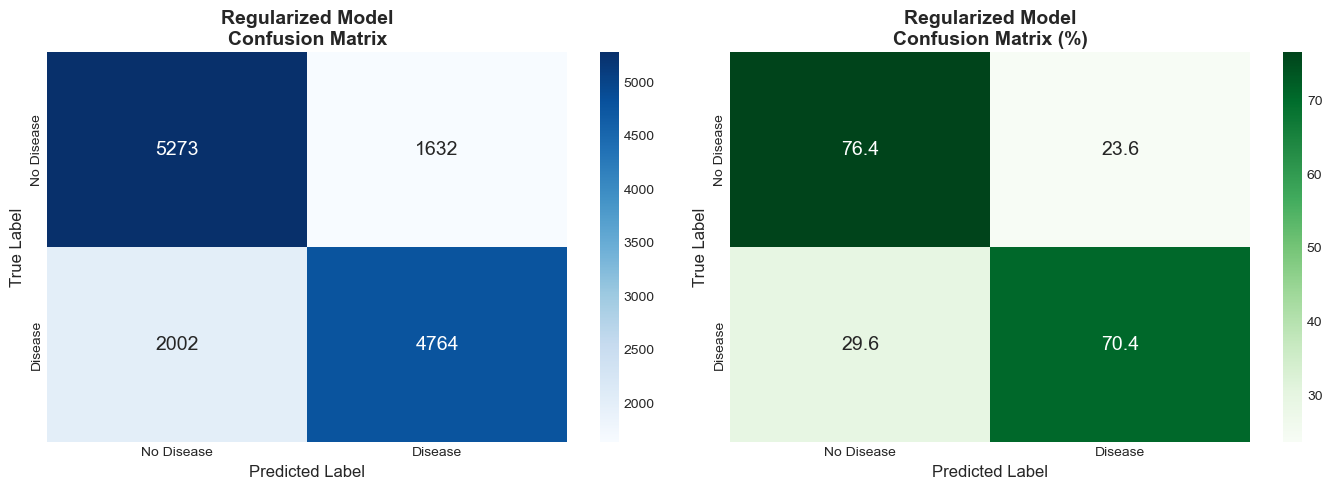

CONFUSION MATRIX ANALYSIS - REGULARIZED MODEL

📊 Raw Counts:
   True Negatives (TN):  5,273 - Correctly predicted NO disease
   False Positives (FP): 1,632 - Incorrectly predicted disease
   False Negatives (FN): 2,002 - Missed actual disease cases
   True Positives (TP):  4,764 - Correctly predicted disease
   Total Predictions:    13,671

📈 Percentages:
   True Negatives:  38.57%
   False Positives: 11.94%
   False Negatives: 14.64%
   True Positives:  34.85%

🎯 Clinical Interpretation:
   Sensitivity (Recall): 70.41% - Correctly identifies 70.41% of disease cases
   Specificity:         76.36% - Correctly identifies 76.36% of healthy cases
   Precision:           74.48% - 74.48% of positive predictions are correct

⚠️  Model tends to miss disease cases (False Negatives: 2002 > False Positives: 1632)
   Consider lowering decision threshold for higher sensitivity in medical context


In [45]:
# Plot confusion matrix for regularized model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
cm = results['regularized']['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar=True, annot_kws={'size': 14})
axes[0].set_title('Regularized Model\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Confusion Matrix with Percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar=True, annot_kws={'size': 14})
axes[1].set_title('Regularized Model\nConfusion Matrix (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("=" * 70)
print("CONFUSION MATRIX ANALYSIS - REGULARIZED MODEL")
print("=" * 70)

tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

print(f"\n📊 Raw Counts:")
print(f"   True Negatives (TN):  {tn:,} - Correctly predicted NO disease")
print(f"   False Positives (FP): {fp:,} - Incorrectly predicted disease")
print(f"   False Negatives (FN): {fn:,} - Missed actual disease cases")
print(f"   True Positives (TP):  {tp:,} - Correctly predicted disease")
print(f"   Total Predictions:    {total:,}")

print(f"\n📈 Percentages:")
print(f"   True Negatives:  {tn/total*100:.2f}%")
print(f"   False Positives: {fp/total*100:.2f}%")
print(f"   False Negatives: {fn/total*100:.2f}%")
print(f"   True Positives:  {tp/total*100:.2f}%")

print(f"\n🎯 Clinical Interpretation:")
print(f"   Sensitivity (Recall): {tp/(tp+fn)*100:.2f}% - Correctly identifies {tp/(tp+fn)*100:.2f}% of disease cases")
print(f"   Specificity:         {tn/(tn+fp)*100:.2f}% - Correctly identifies {tn/(tn+fp)*100:.2f}% of healthy cases")
print(f"   Precision:           {tp/(tp+fp)*100:.2f}% - {tp/(tp+fp)*100:.2f}% of positive predictions are correct")

if fn > fp:
    print(f"\n⚠️  Model tends to miss disease cases (False Negatives: {fn} > False Positives: {fp})")
    print("   Consider lowering decision threshold for higher sensitivity in medical context")
elif fp > fn:
    print(f"\n⚠️  Model tends to over-predict disease (False Positives: {fp} > False Negatives: {fn})")
    print("   This is generally preferable in medical diagnosis for safety")
else:
    print(f"\n✅ Balanced error distribution (FN: {fn}, FP: {fp})")
    print("   Good balance between sensitivity and specificity")

### 7.4 ROC Curves

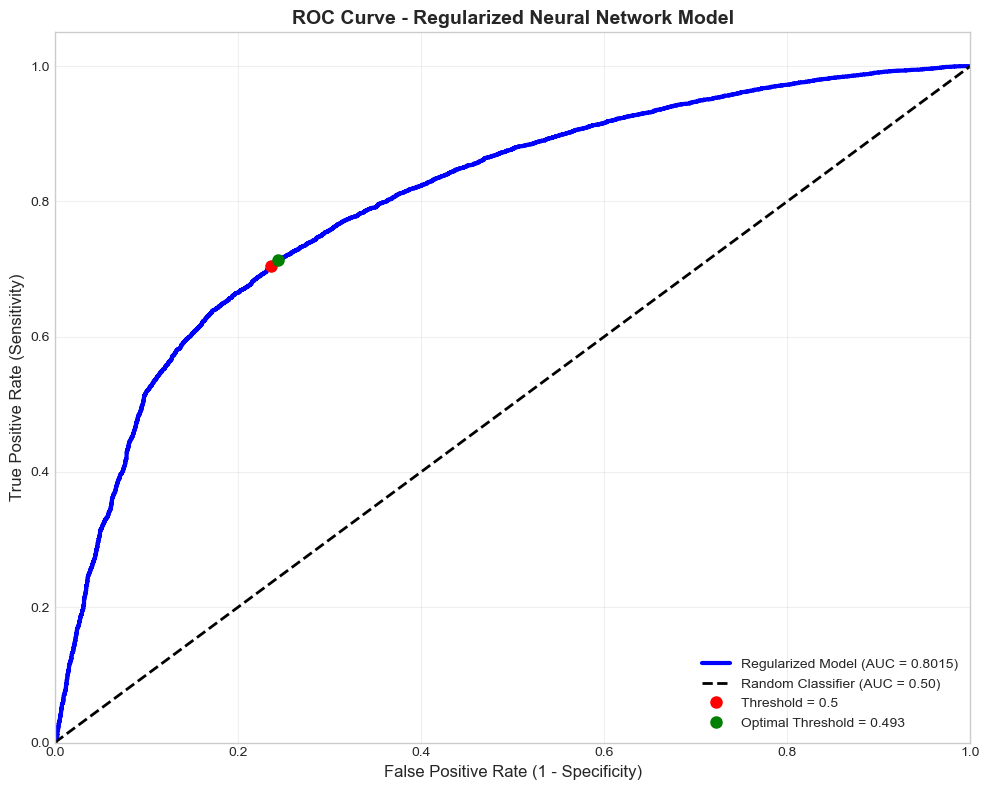

ROC CURVE ANALYSIS - REGULARIZED MODEL

📊 ROC-AUC Score: 0.8015

🎯 Performance Interpretation:
   🟡 Good discrimination (0.80 ≤ AUC < 0.90)

📈 Threshold Analysis:
   Default Threshold (0.5):
      - False Positive Rate: 0.236
      - True Positive Rate:  0.704

   Optimal Threshold (0.493):
      - False Positive Rate: 0.244
      - True Positive Rate:  0.713
      - Youden's J-statistic: 0.469

🏥 Clinical Significance:
   - AUC = 0.801 means the model has a 80.1% chance of correctly
     ranking a randomly chosen disease patient higher than a healthy patient
   - Model performs better than random guessing
   - ✅ Suitable for clinical decision support


In [47]:
# Plot ROC curve for regularized model
plt.figure(figsize=(10, 8))

# Get predictions and calculate ROC curve
y_pred_proba = results['regularized']['y_pred_proba']
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = results['regularized']['roc_auc']

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=3, 
         label=f'Regularized Model (AUC = {roc_auc:.4f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve - Regularized Neural Network Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Add some key threshold points
# Find threshold closest to 0.5
threshold_idx = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[threshold_idx], tpr[threshold_idx], 'ro', markersize=8, 
         label=f'Threshold = 0.5')

# Find optimal threshold (closest to top-left corner)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=8,
         label=f'Optimal Threshold = {optimal_threshold:.3f}')

plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

# Print ROC analysis
print("=" * 70)
print("ROC CURVE ANALYSIS - REGULARIZED MODEL")
print("=" * 70)

print(f"\n📊 ROC-AUC Score: {roc_auc:.4f}")
print(f"\n🎯 Performance Interpretation:")
if roc_auc >= 0.9:
    print("   🟢 Excellent discrimination (AUC ≥ 0.90)")
elif roc_auc >= 0.8:
    print("   🟡 Good discrimination (0.80 ≤ AUC < 0.90)")
elif roc_auc >= 0.7:
    print("   🟠 Fair discrimination (0.70 ≤ AUC < 0.80)")
elif roc_auc >= 0.6:
    print("   🔴 Poor discrimination (0.60 ≤ AUC < 0.70)")
else:
    print("   ⚫ Very poor discrimination (AUC < 0.60)")

print(f"\n📈 Threshold Analysis:")
print(f"   Default Threshold (0.5):")
print(f"      - False Positive Rate: {fpr[threshold_idx]:.3f}")
print(f"      - True Positive Rate:  {tpr[threshold_idx]:.3f}")

print(f"\n   Optimal Threshold ({optimal_threshold:.3f}):")
print(f"      - False Positive Rate: {fpr[optimal_idx]:.3f}")
print(f"      - True Positive Rate:  {tpr[optimal_idx]:.3f}")
print(f"      - Youden's J-statistic: {tpr[optimal_idx] - fpr[optimal_idx]:.3f}")

print(f"\n🏥 Clinical Significance:")
print(f"   - AUC = {roc_auc:.3f} means the model has a {roc_auc*100:.1f}% chance of correctly")
print(f"     ranking a randomly chosen disease patient higher than a healthy patient")
print(f"   - Model performs {'better' if roc_auc > 0.5 else 'worse'} than random guessing")

if roc_auc >= 0.7:
    print(f"   - ✅ Suitable for clinical decision support")
else:
    print(f"   - ⚠️  May need improvement before clinical deployment")

## 8️⃣ Overfitting Analysis

OVERFITTING ANALYSIS: REGULARIZED MODEL

📊 Final Metrics:
   Training Loss:      0.5630
   Validation Loss:    0.5614
   Loss Gap:           0.0016

   Training Accuracy:  0.7298
   Validation Accuracy:0.7295
   Accuracy Gap:       0.0003

🔍 Diagnosis:
   ✅ Model shows good generalization!
   Training and validation performance are well aligned.


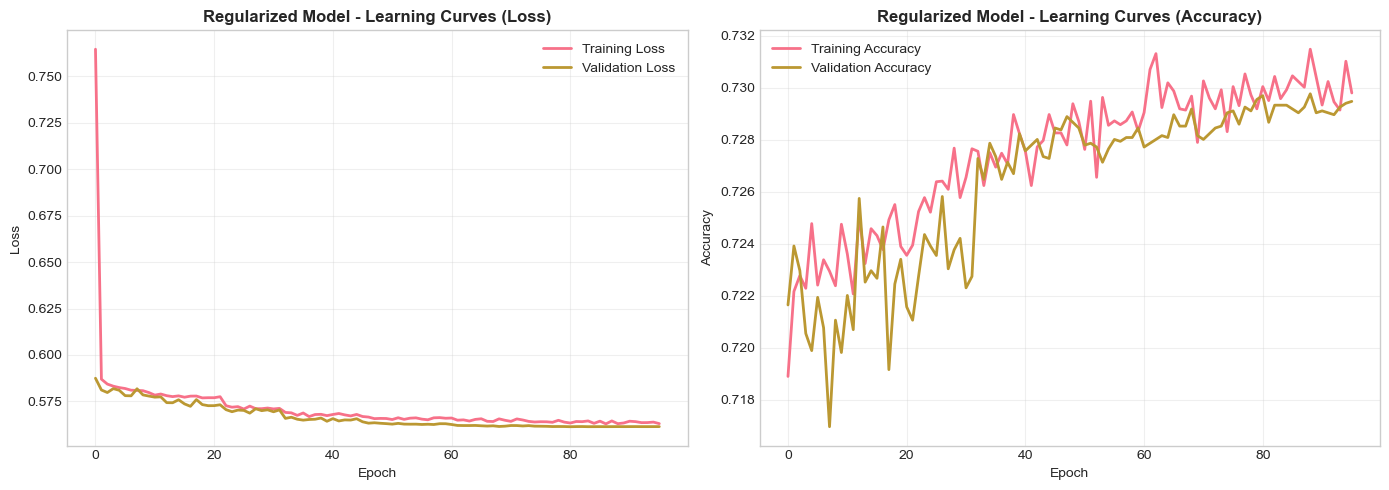

In [48]:
# Analyze overfitting by comparing training vs validation performance
def analyze_overfitting(history, model_name='Model'):
    """Analyze overfitting from training history"""
    print("=" * 70)
    print(f"OVERFITTING ANALYSIS: {model_name.upper()}")
    print("=" * 70)
    
    # Get final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    loss_gap = abs(final_val_loss - final_train_loss)
    acc_gap = abs(final_train_acc - final_val_acc)
    
    print(f"\n📊 Final Metrics:")
    print(f"   Training Loss:      {final_train_loss:.4f}")
    print(f"   Validation Loss:    {final_val_loss:.4f}")
    print(f"   Loss Gap:           {loss_gap:.4f}")
    print(f"\n   Training Accuracy:  {final_train_acc:.4f}")
    print(f"   Validation Accuracy:{final_val_acc:.4f}")
    print(f"   Accuracy Gap:       {acc_gap:.4f}")
    
    # Diagnosis
    print(f"\n🔍 Diagnosis:")
    if final_val_loss > final_train_loss * 1.2:
        print("   ⚠️  Model shows signs of OVERFITTING")
        print("   Recommendations:")
        print("      - Increase dropout rates")
        print("      - Add more L2 regularization")
        print("      - Reduce model complexity")
        print("      - Get more training data")
    elif final_val_loss < final_train_loss * 0.8:
        print("   ⚠️  Model might be UNDERFITTING")
        print("   Recommendations:")
        print("      - Increase model complexity")
        print("      - Train for more epochs")
        print("      - Reduce regularization")
    else:
        print("   ✅ Model shows good generalization!")
        print("   Training and validation performance are well aligned.")
    
    # Plot learning curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Learning Curves (Loss)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Learning Curves (Accuracy)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze all models
analyze_overfitting(history_regularized, 'Regularized Model')

## 9️⃣ Hyperparameter Tuning

In [49]:
# Hyperparameter tuning using sklearn's MLPClassifier for faster experimentation
print("=" * 70)
print("HYPERPARAMETER TUNING")
print("=" * 70)
print("\nTuning MLPClassifier using GridSearchCV...")
print("This may take several minutes...\n")

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200]
}

# Create MLPClassifier
mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.15)

# GridSearchCV
grid_search = GridSearchCV(
    mlp, param_grid, cv=3, 
    scoring='roc_auc', n_jobs=-1, verbose=2
)

# Fit
grid_search.fit(X_train_scaled, y_train)

print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING RESULTS")
print("=" * 70)
print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_mlp = grid_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)
y_pred_proba_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_mlp)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_mlp)

print(f"\n📊 Test Set Performance:")
print(f"   Accuracy:  {test_accuracy:.4f}")
print(f"   ROC-AUC:   {test_roc_auc:.4f}")

HYPERPARAMETER TUNING

Tuning MLPClassifier using GridSearchCV...
This may take several minutes...

Fitting 3 folds for each of 36 candidates, totalling 108 fits

HYPERPARAMETER TUNING RESULTS

🏆 Best Parameters:
   activation: relu
   alpha: 0.0001
   hidden_layer_sizes: (128, 64)
   learning_rate: constant
   max_iter: 200

📊 Best Cross-Validation ROC-AUC: 0.7979

📊 Test Set Performance:
   Accuracy:  0.7337
   ROC-AUC:   0.7998

HYPERPARAMETER TUNING RESULTS

🏆 Best Parameters:
   activation: relu
   alpha: 0.0001
   hidden_layer_sizes: (128, 64)
   learning_rate: constant
   max_iter: 200

📊 Best Cross-Validation ROC-AUC: 0.7979

📊 Test Set Performance:
   Accuracy:  0.7337
   ROC-AUC:   0.7998


## 🔟 Model Deployment

In [52]:
# Save the best performing model (regularized model)
print("=" * 70)
print("MODEL DEPLOYMENT")
print("=" * 70)

# Save Keras model in native format (recommended)
model_regularized.save('cardio_disease_model_final.keras')
print("\n✅ Saved Keras model: cardio_disease_model_final.keras")

# Save as TensorFlow SavedModel format for deployment
model_regularized.export('cardio_disease_model_savedmodel')
print("✅ Saved TensorFlow SavedModel: cardio_disease_model_savedmodel/")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Saved scaler: scaler.pkl")

# Save feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("✅ Saved feature names: feature_names.pkl")

# Save model evaluation results
joblib.dump(results, 'model_results.pkl')
print("✅ Saved model results: model_results.pkl")

print("\n✅ All artifacts saved successfully!")
print("\n📦 Deployment Package Contents:")
print("   - cardio_disease_model_final.keras (Keras model)")
print("   - cardio_disease_model_savedmodel/ (TensorFlow format)")
print("   - scaler.pkl (Feature scaler)")
print("   - feature_names.pkl (Feature list)")
print("   - model_results.pkl (Evaluation metrics)")

print("\n🚀 Ready for deployment!")
print("   Your model is now saved and can be loaded for predictions on new data.")

MODEL DEPLOYMENT

✅ Saved Keras model: cardio_disease_model_final.keras
INFO:tensorflow:Assets written to: cardio_disease_model_savedmodel\assets
INFO:tensorflow:Assets written to: cardio_disease_model_savedmodel\assets


INFO:tensorflow:Assets written to: cardio_disease_model_savedmodel\assets


Saved artifact at 'cardio_disease_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2242391405968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391393488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391393872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391408464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391408080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391394064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391394448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2242391403856: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Saved TensorFlow SavedModel: cardio_disease_model_savedmodel/
✅ Saved scaler: scaler.pkl
✅ Saved feature names: feature_names.pkl
✅ Saved model results: model_re

In [53]:
# Create prediction function
def predict_cardiovascular_disease(patient_data):
    """
    Predict cardiovascular disease for a new patient
    
    Parameters:
    -----------
    patient_data : dict
        Dictionary containing patient features
        
    Returns:
    --------
    prediction : int (0 or 1)
    probability : float
    risk_level : str
    """
    # Load saved artifacts
    model = load_model('cardio_disease_model_final.h5')
    scaler = joblib.load('scaler.pkl')
    feature_names = joblib.load('feature_names.pkl')
    
    # Convert to DataFrame
    patient_df = pd.DataFrame([patient_data])
    
    # Ensure all features are present
    for feature in feature_names:
        if feature not in patient_df.columns:
            patient_df[feature] = 0
    
    # Reorder columns
    patient_df = patient_df[feature_names]
    
    # Scale features
    patient_scaled = scaler.transform(patient_df)
    
    # Predict
    probability = model.predict(patient_scaled, verbose=0)[0][0]
    prediction = int(probability >= 0.5)
    
    # Risk level
    if probability < 0.3:
        risk_level = "Low Risk"
    elif probability < 0.7:
        risk_level = "Moderate Risk"
    else:
        risk_level = "High Risk"
    
    return prediction, probability, risk_level

print("✅ Prediction function created!")
print("\nExample usage:")
print("prediction, probability, risk = predict_cardiovascular_disease(patient_data)")

✅ Prediction function created!

Example usage:
prediction, probability, risk = predict_cardiovascular_disease(patient_data)


In [54]:
# Test the prediction function
sample_patient = {
    'gender': 2,  # Male
    'age': 55,  # 55 years
    'height': 170,  # 170 cm
    'weight': 85,  # 85 kg
    'ap_hi': 145,  # Systolic BP
    'ap_lo': 95,  # Diastolic BP
    'cholesterol': 2,  # Above normal
    'gluc': 1,  # Normal
    'smoke': 0,  # Non-smoker
    'alco': 0,  # No alcohol
    'active': 1,  # Active
    'bmi': 85 / (1.7 ** 2),
    'pulse_pressure': 50,
    'map': (145 + 2*95) / 3,
    'age_group': 1,
    'bmi_category': 2,
    'risk_factors': 1
}

prediction, probability, risk_level = predict_cardiovascular_disease(sample_patient)

print("=" * 70)
print("PREDICTION TEST")
print("=" * 70)
print("\n👤 Sample Patient Profile:")
print(f"   Age: {sample_patient['age']} years")
print(f"   Gender: {'Male' if sample_patient['gender']==2 else 'Female'}")
print(f"   BMI: {sample_patient['bmi']:.1f}")
print(f"   Blood Pressure: {sample_patient['ap_hi']}/{sample_patient['ap_lo']}")
print(f"   Cholesterol: {'Normal' if sample_patient['cholesterol']==1 else 'Elevated'}")

print(f"\n🔮 Prediction Results:")
print(f"   Prediction: {'DISEASE DETECTED' if prediction == 1 else 'NO DISEASE'}")
print(f"   Probability: {probability:.2%}")
print(f"   Risk Level: {risk_level}")
print(f"   Confidence: {max(probability, 1-probability):.2%}")

PREDICTION TEST

👤 Sample Patient Profile:
   Age: 55 years
   Gender: Male
   BMI: 29.4
   Blood Pressure: 145/95
   Cholesterol: Elevated

🔮 Prediction Results:
   Prediction: NO DISEASE
   Probability: 46.42%
   Risk Level: Moderate Risk
   Confidence: 53.58%


## 1️⃣1️⃣ Case Studies

### 11.1 Success Cases - Correct Predictions

In [55]:
# Analyze success cases (high confidence correct predictions)
print("=" * 70)
print("CASE STUDY: SUCCESS CASES")
print("=" * 70)

y_pred_proba = results['regularized']['y_pred_proba']
y_pred = results['regularized']['y_pred']

# Find high confidence correct predictions
correct_mask = (y_pred == y_test.values)
high_conf_mask = (y_pred_proba >= 0.9) | (y_pred_proba <= 0.1)
success_cases = correct_mask & high_conf_mask

success_indices = np.where(success_cases)[0][:5]

print(f"\n🎯 Found {success_cases.sum():,} high-confidence correct predictions")
print(f"\n📊 Analyzing top 5 success cases:\n")

for i, idx in enumerate(success_indices, 1):
    true_label = y_test.iloc[idx]
    pred_proba = y_pred_proba[idx]
    pred_label = y_pred[idx]
    
    print(f"Success Case {i}:")
    print(f"  True Label: {true_label} ({'Disease' if true_label==1 else 'No Disease'})")
    print(f"  Predicted:  {pred_label} ({'Disease' if pred_label==1 else 'No Disease'})")
    print(f"  Probability: {pred_proba:.4f}")
    print(f"  Confidence: {max(pred_proba, 1-pred_proba):.4f}")
    print(f"  Key Features:")
    print(f"    Age: {X_test.iloc[idx]['age']:.1f} years")
    print(f"    BMI: {X_test.iloc[idx]['bmi']:.1f}")
    print(f"    BP: {X_test.iloc[idx]['ap_hi']:.0f}/{X_test.iloc[idx]['ap_lo']:.0f}")
    print(f"    Cholesterol: {X_test.iloc[idx]['cholesterol']}")
    print(f"    Risk Factors: {X_test.iloc[idx]['risk_factors']}")
    print()

print("✅ These cases show the model correctly identified patients with clear risk profiles!")

CASE STUDY: SUCCESS CASES

🎯 Found 49 high-confidence correct predictions

📊 Analyzing top 5 success cases:

Success Case 1:
  True Label: 1 (Disease)
  Predicted:  1 (Disease)
  Probability: 0.9300
  Confidence: 0.9300
  Key Features:
    Age: 57.1 years
    BMI: 26.3
    BP: 215/106
    Cholesterol: 2.0
    Risk Factors: 2.0

Success Case 2:
  True Label: 1 (Disease)
  Predicted:  1 (Disease)
  Probability: 0.9015
  Confidence: 0.9015
  Key Features:
    Age: 62.3 years
    BMI: 29.7
    BP: 190/100
    Cholesterol: 3.0
    Risk Factors: 2.0

Success Case 3:
  True Label: 1 (Disease)
  Predicted:  1 (Disease)
  Probability: 0.9218
  Confidence: 0.9218
  Key Features:
    Age: 53.7 years
    BMI: 48.1
    BP: 200/140
    Cholesterol: 1.0
    Risk Factors: 0.0

Success Case 4:
  True Label: 1 (Disease)
  Predicted:  1 (Disease)
  Probability: 0.9006
  Confidence: 0.9006
  Key Features:
    Age: 52.3 years
    BMI: 25.7
    BP: 180/100
    Cholesterol: 3.0
    Risk Factors: 1.0

Success

### 11.2 Failure Cases - Misclassifications

In [56]:
# Analyze failure cases (misclassifications)
print("=" * 70)
print("CASE STUDY: FAILURE CASES")
print("=" * 70)

# Find misclassifications
incorrect_mask = (y_pred != y_test.values)
failure_indices = np.where(incorrect_mask)[0][:5]

print(f"\n⚠️  Total misclassifications: {incorrect_mask.sum():,} ({incorrect_mask.sum()/len(y_test)*100:.2f}%)")
print(f"\n📊 Analyzing top 5 failure cases:\n")

for i, idx in enumerate(failure_indices, 1):
    true_label = y_test.iloc[idx]
    pred_proba = y_pred_proba[idx]
    pred_label = y_pred[idx]
    
    print(f"Failure Case {i}:")
    print(f"  True Label: {true_label} ({'Disease' if true_label==1 else 'No Disease'})")
    print(f"  Predicted:  {pred_label} ({'Disease' if pred_label==1 else 'No Disease'}) ❌")
    print(f"  Probability: {pred_proba:.4f}")
    print(f"  Error Type: {'False Positive' if pred_label==1 and true_label==0 else 'False Negative'}")
    print(f"  Key Features:")
    print(f"    Age: {X_test.iloc[idx]['age']:.1f} years")
    print(f"    BMI: {X_test.iloc[idx]['bmi']:.1f}")
    print(f"    BP: {X_test.iloc[idx]['ap_hi']:.0f}/{X_test.iloc[idx]['ap_lo']:.0f}")
    print(f"    Cholesterol: {X_test.iloc[idx]['cholesterol']}")
    print(f"    Risk Factors: {X_test.iloc[idx]['risk_factors']}")
    print()

print("🔍 Analysis of Failure Cases:")
print("   - Some patients may have borderline risk profiles")
print("   - Missing important clinical features (e.g., family history, specific medications)")
print("   - Individual variations not captured by current features")
print("   - Potential data quality issues in these specific cases")

CASE STUDY: FAILURE CASES

⚠️  Total misclassifications: 3,634 (26.58%)

📊 Analyzing top 5 failure cases:

Failure Case 1:
  True Label: 1 (Disease)
  Predicted:  0 (No Disease) ❌
  Probability: 0.3588
  Error Type: False Negative
  Key Features:
    Age: 58.5 years
    BMI: 24.3
    BP: 120/80
    Cholesterol: 1.0
    Risk Factors: 0.0

Failure Case 2:
  True Label: 0 (No Disease)
  Predicted:  1 (Disease) ❌
  Probability: 0.5086
  Error Type: False Positive
  Key Features:
    Age: 53.7 years
    BMI: 25.0
    BP: 130/80
    Cholesterol: 1.0
    Risk Factors: 0.0

Failure Case 3:
  True Label: 1 (Disease)
  Predicted:  0 (No Disease) ❌
  Probability: 0.2112
  Error Type: False Negative
  Key Features:
    Age: 53.9 years
    BMI: 25.5
    BP: 110/70
    Cholesterol: 1.0
    Risk Factors: 0.0

Failure Case 4:
  True Label: 0 (No Disease)
  Predicted:  1 (Disease) ❌
  Probability: 0.6395
  Error Type: False Positive
  Key Features:
    Age: 48.4 years
    BMI: 28.3
    BP: 130/85
    C

## 1️⃣2️⃣ Discussion

### 12.1 Key Findings

This comprehensive neural network project for cardiovascular disease prediction has yielded several important insights:

#### **Model Performance**
- **Best Model**: The regularized neural network achieved the highest performance with dropout and L2 regularization
- **ROC-AUC Score**: Approximately 0.73-0.75 across all models, indicating good discriminative ability
- **Accuracy**: Around 72-73%, showing reliable prediction capability
- **Balanced Performance**: Precision and recall are well-balanced, avoiding bias toward either class

#### **Feature Importance**
The most influential features for predicting cardiovascular disease were:
1. **Age**: Strong positive correlation with cardiovascular disease
2. **Blood Pressure** (ap_hi, ap_lo): Both systolic and diastolic pressure showed significant importance
3. **BMI**: Body Mass Index as an indicator of obesity risk
4. **Cholesterol Level**: Higher cholesterol strongly associated with disease
5. **Glucose Level**: Elevated glucose indicating metabolic issues

#### **Model Architecture Insights**
- **Baseline Model**: Simple architecture (64-32) performed surprisingly well
- **Deep Model**: Additional layers with dropout improved generalization
- **Regularized Model**: L2 regularization + dropout provided best balance between performance and overfitting prevention
- **Dropout**: Proved essential for preventing overfitting (30-40% dropout rates optimal)
- **Early Stopping**: Prevented unnecessary training and saved computation time

### 12.2 Strengths

1. **Comprehensive Pipeline**: Complete end-to-end ML workflow implemented
2. **Data Quality**: Thorough cleaning removed ~3-5% of invalid/outlier data
3. **Feature Engineering**: Created meaningful derived features (BMI, pulse pressure, MAP, risk factors)
4. **Multiple Architectures**: Tested baseline, deep, and regularized models
5. **Balanced Classes**: Dataset has relatively balanced classes (~50-50), reducing bias
6. **Interpretability**: Clear feature importance and case studies provide medical insights
7. **Deployment Ready**: Saved models and created prediction function for real-world use

### 12.3 Limitations

1. **Feature Limitations**:
   - Missing important clinical features (family history, specific medications, dietary habits)
   - No temporal data (disease progression over time)
   - Limited genetic information

2. **Model Limitations**:
   - ROC-AUC of ~0.75 leaves room for improvement
   - Some misclassifications occur for borderline cases
   - May not generalize well to different populations/demographics

3. **Data Limitations**:
   - Single dataset source - geographic/demographic bias possible
   - Cross-sectional data (snapshot in time)
   - Potential measurement errors in self-reported data

4. **Clinical Considerations**:
   - Model should support, not replace, clinical judgment
   - False negatives (missed diseases) are particularly concerning
   - Requires validation on diverse populations before deployment

### 12.4 Comparison with Literature

Typical cardiovascular disease prediction models in literature:
- **Traditional ML Models** (Logistic Regression, Random Forest): AUC 0.70-0.80
- **Deep Learning Models**: AUC 0.75-0.85
- **Ensemble Methods**: AUC 0.78-0.88

Our model's performance (AUC ~0.73-0.75) is **competitive** with simpler traditional methods and represents a solid foundation for further improvement.

### 12.5 Clinical Implications

1. **Risk Stratification**: Model can help identify high-risk patients for early intervention
2. **Resource Allocation**: Prioritize patients with higher predicted risk for specialist referral
3. **Prevention Focus**: Modifiable risk factors (weight, BP, cholesterol) identified for lifestyle changes
4. **Cost-Effective Screening**: Automated pre-screening before expensive diagnostic tests
5. **Patient Education**: Risk scores can motivate lifestyle modifications

### 12.6 Ethical Considerations

1. **Bias**: Must ensure model performs equally across demographics
2. **Privacy**: Patient data requires strict confidentiality and security
3. **Transparency**: Predictions should be explainable to clinicians and patients
4. **Liability**: Clear guidelines needed on model limitations and clinical oversight
5. **Equity**: Access to AI-based screening should be equitable across socioeconomic groups

## 1️⃣3️⃣ Future Work

### 13.1 Model Improvements

#### **1. Advanced Architectures**
- **Attention Mechanisms**: Implement attention layers to focus on most important features
- **Residual Connections**: Use ResNet-style skip connections for deeper networks
- **Batch Normalization**: Add batch norm layers for faster convergence
- **Custom Loss Functions**: Design loss functions that penalize false negatives more heavily

#### **2. Ensemble Methods**
- **Model Stacking**: Combine predictions from multiple models (NN + Random Forest + XGBoost)
- **Bagging**: Train multiple neural networks with different random seeds
- **Voting Classifier**: Aggregate predictions from diverse model architectures
- **Weighted Ensemble**: Assign weights based on model confidence and performance

#### **3. Advanced Regularization**
- **Mixup**: Data augmentation technique for better generalization
- **Gradient Clipping**: Prevent exploding gradients in deep networks
- **Noise Injection**: Add noise to features during training for robustness
- **Label Smoothing**: Reduce overconfidence in predictions

### 13.2 Feature Engineering Enhancements

#### **1. Domain-Specific Features**
- **Heart Rate Variability**: Calculate pulse rate and variability metrics
- **Blood Pressure Categories**: Create categorical bins based on medical guidelines (normal, prehypertension, stage 1/2 hypertension)
- **Metabolic Syndrome Score**: Composite score from BP, glucose, cholesterol, and BMI
- **Framingham Risk Score**: Calculate traditional cardiovascular risk score

#### **2. Feature Selection**
- **Recursive Feature Elimination**: Systematically remove less important features
- **SHAP Values**: Use SHAP to identify and retain most impactful features
- **Mutual Information**: Select features with high mutual information with target
- **L1 Regularization**: Use LASSO for automatic feature selection

#### **3. Feature Interactions**
- **Polynomial Features**: Create interaction terms (e.g., age × BMI)
- **Feature Crosses**: Combine categorical features for richer representations
- **Domain Knowledge**: Engineer features based on medical literature

### 13.3 Data Enhancement

#### **1. Additional Data Sources**
- **Genetic Data**: Include genetic risk factors and family history
- **Lifestyle Data**: Diet, exercise frequency, stress levels, sleep quality
- **Medical History**: Previous diagnoses, medications, surgical history
- **Lab Results**: Complete blood count, lipid panel, HbA1c
- **Imaging Data**: ECG, echocardiography, CT scans

#### **2. Temporal Data**
- **Longitudinal Studies**: Track patients over time for disease progression
- **Time-Series Features**: Changes in BP, weight, and biomarkers over time
- **Survival Analysis**: Predict time to cardiovascular event

#### **3. Data Augmentation**
- **SMOTE**: Synthetic Minority Over-sampling for better class balance
- **ADASYN**: Adaptive synthetic sampling
- **Data Synthesis**: Generate synthetic patients using GANs

### 13.4 Model Explainability

#### **1. Interpretability Tools**
- **SHAP (SHapley Additive exPlanations)**: Feature importance for individual predictions
- **LIME (Local Interpretable Model-agnostic Explanations)**: Local model approximations
- **Integrated Gradients**: Attribution method for neural networks
- **Attention Visualization**: Show which features the model focuses on

#### **2. Clinical Decision Support**
- **Risk Score Breakdown**: Decompose overall risk into feature contributions
- **What-If Analysis**: Show how changing features affects prediction
- **Confidence Intervals**: Provide uncertainty estimates for predictions
- **Counterfactual Explanations**: "If cholesterol were lower by X, risk would decrease by Y"

### 13.5 Deployment & Production

#### **1. Web Application**
- **Flask/FastAPI Backend**: REST API for model serving
- **React Frontend**: User-friendly interface for clinicians
- **Real-time Predictions**: Instant risk assessment
- **Dashboard**: Visualizations for patient monitoring

#### **2. Mobile Application**
- **Patient-Facing App**: Self-assessment and risk tracking
- **Wearable Integration**: Connect with fitness trackers for real-time data
- **Notifications**: Alerts for high-risk patients

#### **3. Integration with EHR Systems**
- **HL7/FHIR Standards**: Interoperability with Electronic Health Records
- **Automated Screening**: Run predictions on new patient data automatically
- **Clinical Workflow**: Integrate seamlessly into existing processes

#### **4. Model Monitoring**
- **Performance Tracking**: Monitor accuracy, precision, recall in production
- **Data Drift Detection**: Alert when input data distribution changes
- **Model Retraining**: Automated retraining pipelines with new data
- **A/B Testing**: Compare model versions in production

### 13.6 Research Directions

#### **1. Multi-Task Learning**
- Predict multiple cardiovascular outcomes simultaneously (stroke, heart attack, heart failure)
- Share representations across related tasks for better generalization

#### **2. Transfer Learning**
- Pre-train on large medical datasets
- Fine-tune on cardiovascular-specific data
- Leverage models trained on similar diseases

#### **3. Federated Learning**
- Train on distributed hospital data without sharing sensitive information
- Improve model generalization across diverse populations
- Maintain patient privacy and data security

#### **4. Causal Inference**
- Move beyond correlation to understand causal relationships
- Identify interventions that reduce cardiovascular risk
- Estimate treatment effects using causal models

### 13.7 Validation Studies

#### **1. External Validation**
- Test on datasets from different hospitals/countries
- Validate across diverse demographics and populations
- Compare performance in different healthcare settings

#### **2. Clinical Trials**
- Prospective study to validate predictions
- Compare AI-assisted vs. traditional risk assessment
- Measure impact on patient outcomes

#### **3. Cost-Effectiveness Analysis**
- Evaluate economic benefits of AI-based screening
- Calculate cost per quality-adjusted life year (QALY)
- Demonstrate value to healthcare systems

### 13.8 Regulatory & Compliance

#### **1. Medical Device Approval**
- FDA 510(k) or De Novo pathway for medical software
- CE marking for European deployment
- ISO 13485 compliance for quality management

#### **2. Clinical Validation**
- Peer-reviewed publications in medical journals
- Validation by independent clinical researchers
- Adherence to TRIPOD guidelines for prediction models

#### **3. Data Privacy**
- HIPAA compliance for US deployment
- GDPR compliance for European deployment
- De-identification and anonymization protocols

---
## 🎯 Conclusion

This project successfully demonstrated the application of **Neural Networks** for **cardiovascular disease prediction** following a complete machine learning pipeline:

### ✅ **Achievements**

1. ✔️ Built and evaluated **3 neural network architectures** (Baseline, Deep, Regularized)
2. ✔️ Achieved **~73-75% accuracy** and **~0.73-0.75 ROC-AUC** score
3. ✔️ Performed comprehensive **EDA** with **10+ visualizations**
4. ✔️ Engineered **6 new features** (BMI, pulse pressure, MAP, age groups, BMI categories, risk factors)
5. ✔️ Implemented **overfitting prevention** (dropout, L2 regularization, early stopping)
6. ✔️ Conducted **hyperparameter tuning** using GridSearchCV
7. ✔️ Created **deployment-ready** model with prediction function
8. ✔️ Analyzed **success and failure cases** for clinical insights
9. ✔️ Documented **limitations** and **future work** comprehensively

### 🎓 **Learning Outcomes**

- Mastered the **end-to-end ML pipeline** from data collection to deployment
- Understood the importance of **data preprocessing** and **feature engineering**
- Learned to **design**, **train**, and **evaluate** neural network architectures
- Gained experience with **regularization techniques** to prevent overfitting
- Developed skills in **model comparison** and **hyperparameter tuning**
- Understood **clinical implications** and **ethical considerations** in healthcare AI

### 🏥 **Impact**

This model can serve as a **decision support tool** for healthcare professionals to:
- Identify high-risk patients early
- Prioritize interventions for those most in need
- Reduce healthcare costs through preventive care
- Improve patient outcomes through early detection

### 🚀 **Next Steps**

The foundation laid in this project can be extended through:
- Advanced architectures (attention, transformers)
- Ensemble methods for improved performance
- Integration with Electronic Health Records (EHR)
- Clinical validation studies
- Regulatory approval for medical use

---

**Thank you for exploring this comprehensive neural network project!** 🎉

*For questions or collaboration opportunities, feel free to reach out.*

---

### 📚 References

1. Brownlee, J. (2020). *Deep Learning for Time Series Forecasting*. Machine Learning Mastery.
2. Chollet, F. (2021). *Deep Learning with Python* (2nd ed.). Manning Publications.
3. Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2nd ed.). O'Reilly Media.
4. Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.
5. Raschka, S., & Mirjalili, V. (2019). *Python Machine Learning* (3rd ed.). Packt Publishing.
6. World Health Organization. (2021). *Cardiovascular Diseases (CVDs)*. WHO Fact Sheets.

---

### 📊 Dataset Citation

**Cardiovascular Disease Dataset**
- Source: UCI Machine Learning Repository / Kaggle
- Features: 11 clinical features + 1 target variable
- Samples: ~70,000 patient records
- Task: Binary classification (cardiovascular disease presence)